In [4]:
# Original Author: Aditya Jain
# Created at: September 13, 2019
# Last Modified: April 11, 2020
# The code may be adapted and used for non-commercial reasons after citing original authors

In [1]:
import pandas as pd
import numpy as np
import shap
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats  import entropy
from scipy.linalg import svd
from sklearn.decomposition import PCA, NMF
import sklearn
import numpy as np
from collections import namedtuple
import pandas as pd
from collections import Counter
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cvxpy as cvx
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy.stats import wasserstein_distance

In [1]:
processed_data_file = "../data/compas_processed.csv"
try:
    data_final = pd.read_csv(processed_data_file)
except:
    print("Processed File not found.... Generating new file")
    data = pd.read_csv("../data/compas-scores-two-years.csv")
    data = data.query("race != 'Asian'").query("race != 'Native American'").query("race != 'Other'").query("race != 'Hispanic'")
    data.race.value_counts()
    data.groupby(['c_charge_degree','is_recid'])['id'].count().reset_index()

    data['c_charge_degree'] = pd.Categorical(data['c_charge_degree'])
    dummies =pd.get_dummies(data['c_charge_degree'], prefix = 'charge')
    data =  pd.concat([data, dummies], axis = 1)
    data['age_cat'] =  [x.replace(' ', '').replace("-",'_') for x in data['age_cat']]
    data['race'] = [x.replace(" ", "").replace("-",'_') for x in data['race']]


    data = data.query("days_b_screening_arrest <= 30") \
            .query("days_b_screening_arrest >= -30")\
            .query("is_recid != -1")\
            .query("c_charge_degree != 'O'") \
            .query("score_text != 'N/A'" )

    print(data.shape)

    # Setting Seed to reproduce randomness
    # np.random.seed(100)
    data['race_random'] = np.random.permutation(data['race'])

    columns_selected = ['age', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                        'c_charge_degree', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'race_random'
               ]

    data_final = data.loc[:, columns_selected]


    factor_columns = ['age_cat', 'race', 'sex','c_charge_degree', 'race_random']


    for name in factor_columns:
        dummies =  pd.get_dummies(data_final[name]).rename( columns =  lambda x: name+'_' +  str(x) )
        data_final =  pd.concat([data_final, dummies], axis = 1).drop([name], axis  = 1)
    data_final['score_factor'] =  np.where(data_final['score_text'] == 'Low', 'Low', 'MediumHigh')
    dummies =pd.get_dummies(data_final['score_factor'])
    data_final = pd.concat([data_final, dummies] , axis = 1)
    data_final.reset_index(inplace = True)
    data_final.to_csv(processed_data_file, index = False)

finally:
    print(data_final.head())



Processed File not found.... Generating new file


NameError: name 'data_final' is not defined

In [3]:
np.sum(data_final['race_African_American']==data_final['race_random_African_American'])

2714

In [4]:
print(data_final.groupby(['race_African_American','is_recid'])['index'].count().reset_index())
print("Base Rate Caucasian ",  (874/ (1229 + 874)))
print("Base Rate African_American ",  (1773/ (1773 + 1402)))

   race_African_American  is_recid  index
0                      0         0   1229
1                      0         1    874
2                      1         0   1402
3                      1         1   1773
Base Rate Caucasian  0.41559676652401334
Base Rate African_American  0.5584251968503937


vPreprocessing Data as given by Compas dataset

# Working on XGBOOST Training of the problem

 Here we train an XGBoost model on COMPAS Predictions to identify potential biases
 
 Here we Model for Y = 1 being a low score as predicted by COMPAS and thus a favourable outcome


In [5]:

independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25', 'race_African_American',
       'race_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']

# 'race_random_African_American',
#        'race_random_Caucasian',
X =  data_final.loc[:, independent_columns]
y =  data_final['Low']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
try:
    model = pickle.load(open("../model/model_normal.pickle.dat", "rb"))
    print("Existing Model Found")
except:
    print("Model Not Found, Generating Model")
    params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
    }
    model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
    xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
    
    pickle.dump(model, open("../model/model_normal.pickle.dat", "wb"))

finally:
    data_final['pred'] = model.predict(xgb_full)





Existing Model Found


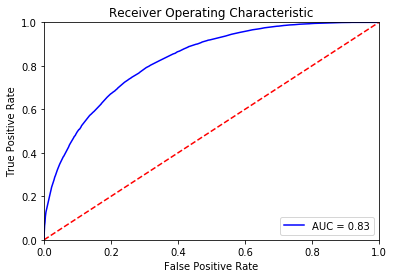

Optimal Threshold obtained using difference of TPR and FPR 0.49731418


In [6]:
fpr, tpr , thresholds = roc_curve(data_final['Low'], data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

In [7]:

race_afam = data_final[(data_final['race_African_American']==1)].index
race_caucasian = data_final[(data_final['race_African_American']==0)].index

print("Number of Caucasian  is " + str(len(race_caucasian)))
print("Number of African American  is " + str(len(race_afam)))



location_afam  =  X.columns.get_loc("race_African_American")
location_caucasian =X.columns.get_loc("race_Caucasian")
#location_hispanic = X.columns.get_loc("race_Hispanic")
location_mis = X.columns.get_loc("c_charge_degree_M")
location_fel = X.columns.get_loc("c_charge_degree_F")
#location_rand = X.columns.get_loc("race_random_African_American")

#locations_interested = [location_afam,location_caucasian, location_rand]

Number of Caucasian  is 2103
Number of African American  is 3175


In [8]:
shap_file_name="../data/shap_normal.csv" 

try:  
    print("Reading SHAP Value file at ", shap_file_name)
    shap_values =  pd.read_csv(shap_file_name).values
except:
    print("SHAP Values file not found at ", shap_file_name, "Generating File ")
    background = sklearn.utils.resample(X, n_samples=100, replace=True)
    explainer = shap.TreeExplainer(model ,background, feature_dependence = 'independent', model_output = 'probability')
    shap_values =  explainer.shap_values(X)
    shap_df1 = pd.DataFrame(shap_values, columns=independent_columns)
    shap_df1.to_csv(shap_file_name, index = False)
finally:
    print(shap_values.shape)

Reading SHAP Value file at  ../data/shap_normal.csv
(5278, 10)


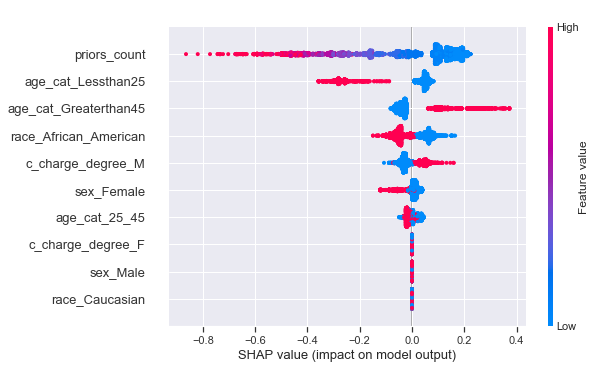

In [9]:
sns.set()
shap.summary_plot(shap_values, X)

In [10]:
Y_1_AF =  data_final[(data_final['is_recid']==0) & (data_final['race_African_American']==1)].index
Y_1_C = data_final[(data_final['is_recid']==0) & (data_final['race_African_American']==0)].index


Y_0_AF =  data_final[(data_final['is_recid']==1) & (data_final['race_African_American']==1)].index
Y_0_C = data_final[(data_final['is_recid']==1) & (data_final['race_African_American']==0)].index

Y_1_AF_random =  data_final[(data_final['is_recid']==0) & (data_final['race_random_African_American']==1)].index
Y_1_C_random = data_final[(data_final['is_recid']==0) & (data_final['race_random_African_American']==0)].index




Y_0_AF_random =  data_final[(data_final['is_recid']==1) & (data_final['race_random_African_American']==1)].index
Y_0_C_random = data_final[(data_final['is_recid']==1) & (data_final['race_random_African_American']==0)].index

# print(len(Y_0_AF))
# print(len(Y_0_C))
# print(len(Y_0_AF_random))
# print(len(Y_0_C_random))
# print()

# print(len(Y_1_AF))
# print(len(Y_1_C))
# print(len(Y_1_AF_random))
# print(len(Y_1_C_random))

# Checking distributions of SHAP Values for different combinations of Feature x Protected Attribute x Outcome

In [11]:
independent_columns

['priors_count',
 'age_cat_25_45',
 'age_cat_Greaterthan45',
 'age_cat_Lessthan25',
 'race_African_American',
 'race_Caucasian',
 'sex_Female',
 'sex_Male',
 'c_charge_degree_M',
 'c_charge_degree_F']

wasserstein's distance  for Y==1 0.05727431277180884
wasserstein's distance  for Y==0 0.05276712618550719


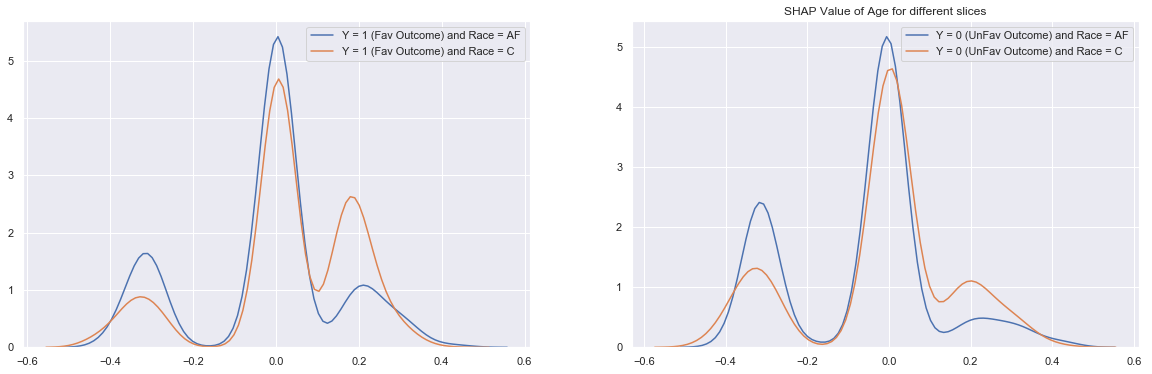

In [17]:
f, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.title("SHAP Value of Age for different slices")
shap_age = shap_values[:, 1] + shap_values[:,2] + shap_values[:,3]
sns.kdeplot(shap_age[Y_1_AF], label = 'Y = 1 (Fav Outcome) and Race = AF', ax=axes[0])
sns.kdeplot(shap_age[Y_1_C], label = 'Y = 1 (Fav Outcome) and Race = C', ax=axes[0])
print("wasserstein's distance  for Y==1", wasserstein_distance(shap_age[Y_1_AF],shap_age[Y_1_C] ))
print("wasserstein's distance  for Y==0", wasserstein_distance(shap_age[Y_0_AF],shap_age[Y_0_C] ))

sns.kdeplot(shap_age[Y_0_AF], label = 'Y = 0 (UnFav Outcome) and Race = AF' , ax=axes[1])
sns.kdeplot(shap_age[Y_0_C], label = 'Y = 0 (UnFav Outcome) and Race = C', ax=axes[1])


wasserstein's distance  for Y==1 0.06314927651798055
wasserstein's distance  for Y==0 0.08744894759815494


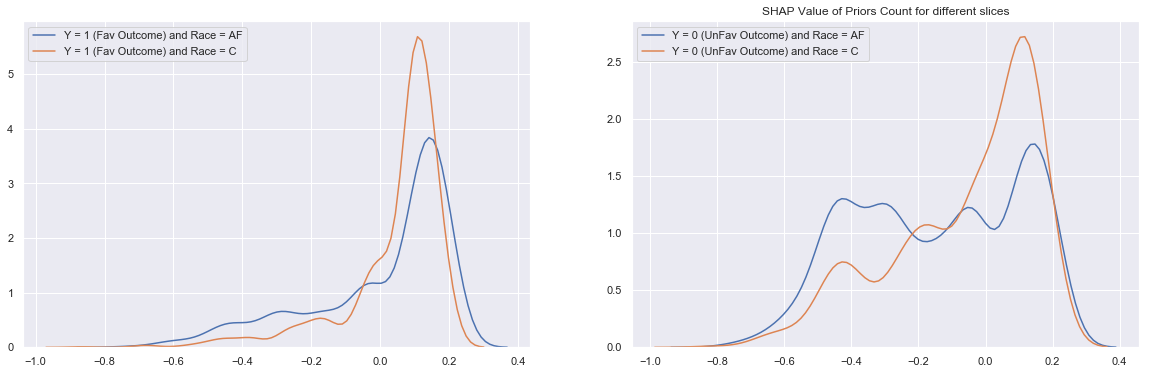

In [18]:
f, axes = plt.subplots(1, 2, figsize=(20, 6))
shap_age = shap_values[:, 0]
plt.title("SHAP Value of Priors Count for different slices")
sns.kdeplot(shap_age[Y_1_AF], label = 'Y = 1 (Fav Outcome) and Race = AF', ax=axes[0])
sns.kdeplot(shap_age[Y_1_C], label = 'Y = 1 (Fav Outcome) and Race = C', ax=axes[0])
print("wasserstein's distance  for Y==1", wasserstein_distance(shap_age[Y_1_AF],shap_age[Y_1_C] ))
print("wasserstein's distance  for Y==0", wasserstein_distance(shap_age[Y_0_AF],shap_age[Y_0_C] ))

sns.kdeplot(shap_age[Y_0_AF], label = 'Y = 0 (UnFav Outcome) and Race = AF' , ax=axes[1])
sns.kdeplot(shap_age[Y_0_C], label = 'Y = 0 (UnFav Outcome) and Race = C', ax=axes[1])


wasserstein's distance  for Y==1 0.014578018147196711
wasserstein's distance  for Y==0 0.015743989970299285


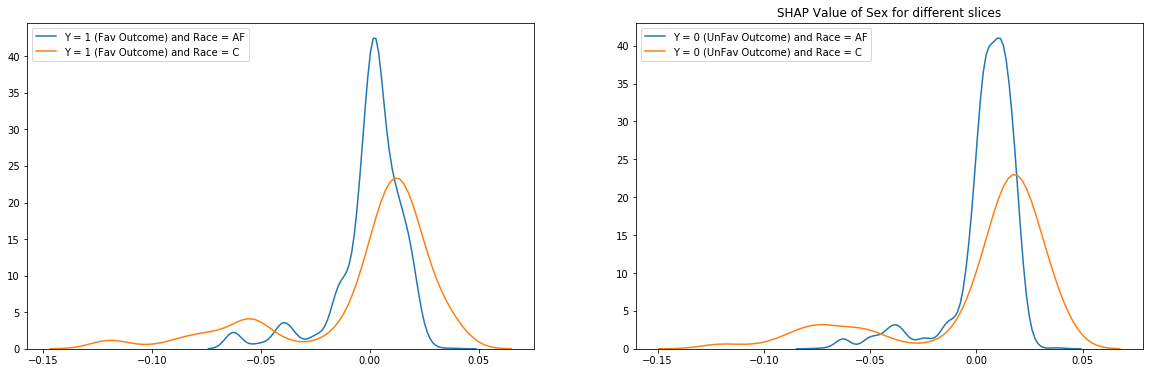

In [24]:
f, axes = plt.subplots(1, 2, figsize=(20, 6))
shap_age = shap_values[:, 6]
plt.title("SHAP Value of Sex for different slices")
sns.kdeplot(shap_age[Y_1_AF], label = 'Y = 1 (Fav Outcome) and Race = AF', ax=axes[0])
sns.kdeplot(shap_age[Y_1_C], label = 'Y = 1 (Fav Outcome) and Race = C', ax=axes[0])
print("wasserstein's distance  for Y==1", wasserstein_distance(shap_age[Y_1_AF],shap_age[Y_1_C] ))
print("wasserstein's distance  for Y==0", wasserstein_distance(shap_age[Y_0_AF],shap_age[Y_0_C] ))

sns.kdeplot(shap_age[Y_0_AF], label = 'Y = 0 (UnFav Outcome) and Race = AF' , ax=axes[1])
sns.kdeplot(shap_age[Y_0_C], label = 'Y = 0 (UnFav Outcome) and Race = C', ax=axes[1])


wasserstein's distance  for Y==1 0.013576820334399062
wasserstein's distance  for Y==0 0.011269850702293124


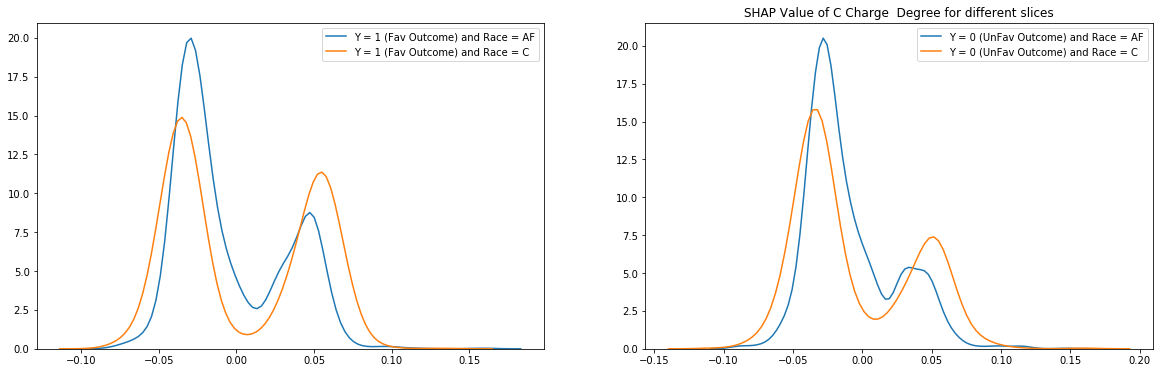

In [25]:
f, axes = plt.subplots(1, 2, figsize=(20, 6))
shap_age = shap_values[:, 8]
plt.title("SHAP Value of C Charge  Degree for different slices")
sns.kdeplot(shap_age[Y_1_AF], label = 'Y = 1 (Fav Outcome) and Race = AF', ax=axes[0])
sns.kdeplot(shap_age[Y_1_C], label = 'Y = 1 (Fav Outcome) and Race = C', ax=axes[0])
print("wasserstein's distance  for Y==1", wasserstein_distance(shap_age[Y_1_AF],shap_age[Y_1_C] ))
print("wasserstein's distance  for Y==0", wasserstein_distance(shap_age[Y_0_AF],shap_age[Y_0_C] ))

sns.kdeplot(shap_age[Y_0_AF], label = 'Y = 0 (UnFav Outcome) and Race = AF' , ax=axes[1])
sns.kdeplot(shap_age[Y_0_C], label = 'Y = 0 (UnFav Outcome) and Race = C', ax=axes[1])



wasserstein's distance  for Y==1 0.10037652115140139
wasserstein's distance  for Y==0 0.11507719500631139


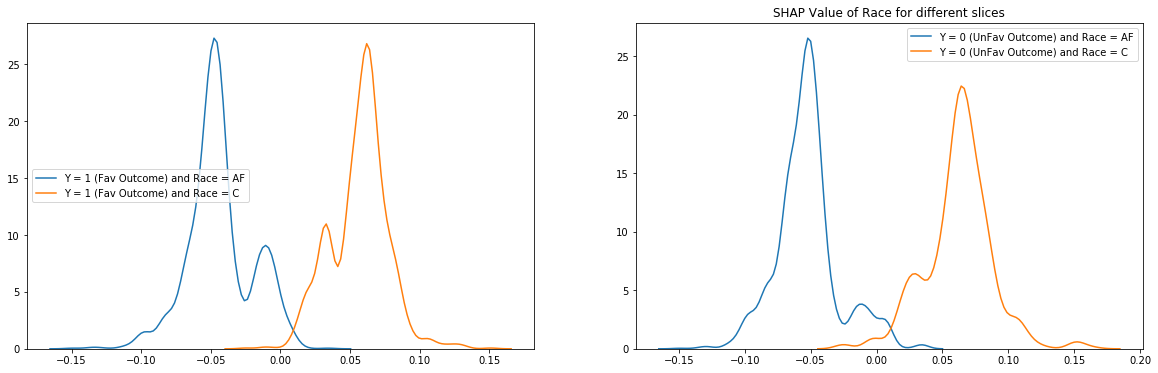

In [26]:
f, axes = plt.subplots(1, 2, figsize=(20, 6))
shap_age = shap_values[:, 4]
plt.title("SHAP Value of Race for different slices")
sns.kdeplot(shap_age[Y_1_AF], label = 'Y = 1 (Fav Outcome) and Race = AF', ax=axes[0])
sns.kdeplot(shap_age[Y_1_C], label = 'Y = 1 (Fav Outcome) and Race = C', ax=axes[0])
print("wasserstein's distance  for Y==1", wasserstein_distance(shap_age[Y_1_AF],shap_age[Y_1_C] ))
print("wasserstein's distance  for Y==0", wasserstein_distance(shap_age[Y_0_AF],shap_age[Y_0_C] ))

sns.kdeplot(shap_age[Y_0_AF], label = 'Y = 0 (UnFav Outcome) and Race = AF' , ax=axes[1])
sns.kdeplot(shap_age[Y_0_C], label = 'Y = 0 (UnFav Outcome) and Race = C', ax=axes[1])


Some difference in distribution of SHAP Values of features corresponds to base rate being different. The difference in base rates (0.15 here) would be divided into difference in SHAP Values for different features. Ideally the SHAP Value for race would not be different 

wasserstein's distance  for Race AF and C 0.10776085480180225


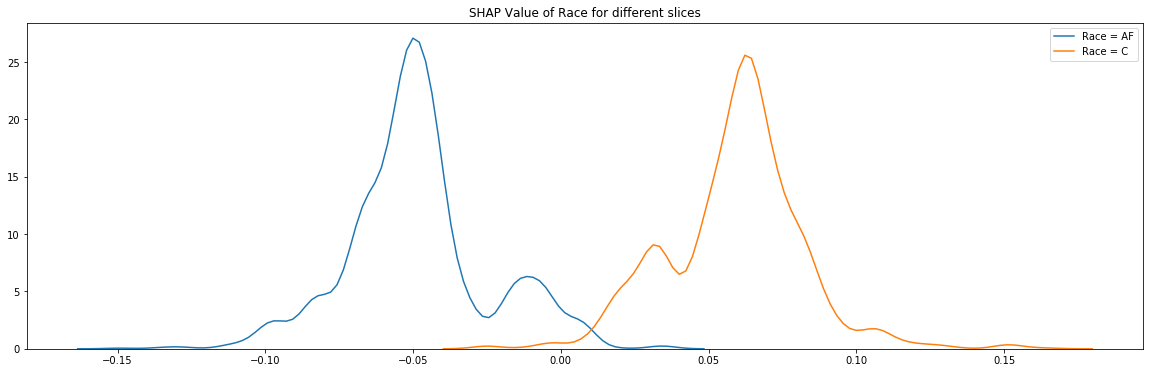

In [27]:
f, axes = plt.subplots(1, 1, figsize=(20, 6))
shap_age = shap_values[:, 4]
plt.title("SHAP Value of Race for different slices")
sns.kdeplot(shap_age[Y_1_AF.union(Y_0_AF)], label = 'Race = AF')
sns.kdeplot(shap_age[Y_1_C.union(Y_0_C)], label = 'Race = C')
print("wasserstein's distance  for Race AF and C", wasserstein_distance(shap_age[Y_1_AF.union(Y_0_AF)], shap_age[Y_1_C.union(Y_0_C)]))

# Quantifying discrimination

In [19]:
# Wasserstein distance
wasserstein_distance(shap_age[Y_1_AF.union(Y_0_AF)], shap_age[Y_1_C.union(Y_0_C)])

0.10776085480180225

# Check for consistency for SHAP Values
1. Calculate mean and take some of all areas

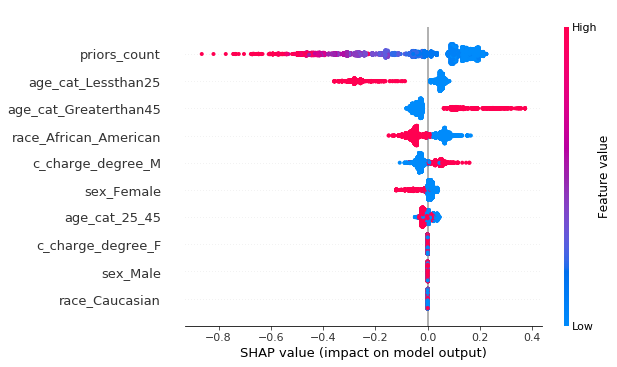

In [36]:
shap.summary_plot(shap_values, X)

# Checking for different feature interaction

4


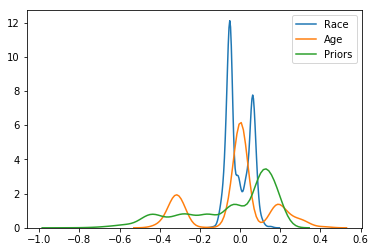

In [45]:
sns.kdeplot(shap_values[:, location_afam], label = 'Race')
print(location_afam)
shap_age = shap_values[:, 1] + shap_values[:,2] + shap_values[:,3]
sns.kdeplot(shap_age, label = 'Age')
sns.kdeplot(shap_values[:, 0], label = 'Priors')


# Randomizing race and removing the original race column

As compared to the previous mimic model of having both the race and the randomized race together in the same dataset. The following experiment truly looks at a randomized race column. The hypothesis of the experiement was motivated from the fact that since SHAP values for the original race column already captured the effect of race, thus leaving no attribution to the randomized race column.

Here we might see the in effectiveness of race blindness.

In [12]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']


X =  data_final.loc[:, independent_columns]
y =  data_final['Low']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees



try:
    model = pickle.load(open("../model/model_random.pickle.dat", "rb"))
    print("Existing Model Found")
except:
    print("Model Not Found, Generating Model")
    params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
    }
    model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
    xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
    
    pickle.dump(model, open("../model/model_random.pickle.dat", "wb"))

finally:
    data_final['pred'] = model.predict(xgb_full)


Existing Model Found


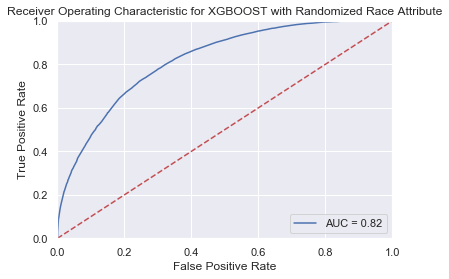

Optimal Threshold obtained using difference of TPR and FPR 0.5109512


In [13]:
fpr, tpr , thresholds = roc_curve(data_final['Low'], data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for XGBOOST with Randomized Race Attribute')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

In [14]:
shap_file_name="../data/shap_random.csv" 

try:  
    print("Reading SHAP Value file at ", shap_file_name)
    shap_values_random =  pd.read_csv(shap_file_name).values
except:
    print("SHAP Values file not found at ", shap_file_name, "Generating File ")
    background = sklearn.utils.resample(X, n_samples=100, replace=True)
    explainer = shap.TreeExplainer(model ,background, feature_dependence = 'independent', model_output = 'probability')
#     explainer = shap.TreeExplainer(model)
    shap_values_random =  explainer.shap_values(X)
    shap_df2 = pd.DataFrame(shap_values_random, columns=independent_columns)
    shap_df2.to_csv(shap_file_name, index = False)
finally:
    print(shap_values_random.shape)

Reading SHAP Value file at  ../data/shap_random.csv
(5278, 10)


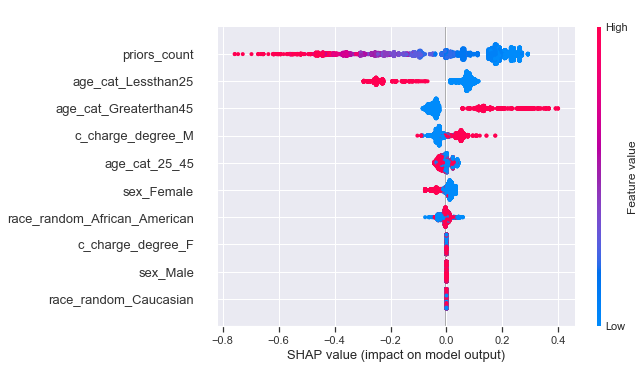

In [58]:
sns.set()
shap.summary_plot(shap_values_random, X)

wasserstein's distance  for Y==1 0.012231491126593167
wasserstein's distance  for Y==0 0.010420689799934232


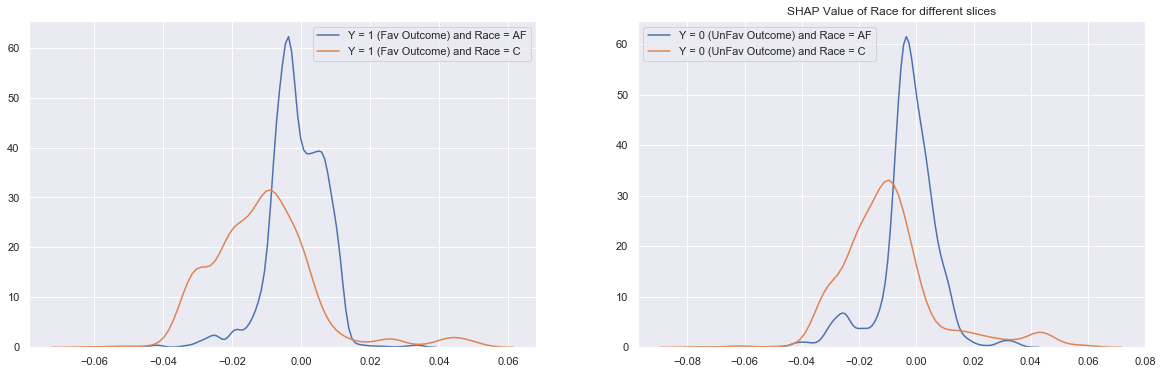

In [15]:
f, axes = plt.subplots(1, 2, figsize=(20, 6))
shap_age = shap_values_random[:, 4]
plt.title("SHAP Value of Race for different slices")
sns.kdeplot(shap_age[Y_1_AF_random], label = 'Y = 1 (Fav Outcome) and Race = AF', ax=axes[0])
sns.kdeplot(shap_age[Y_1_C_random], label = 'Y = 1 (Fav Outcome) and Race = C', ax=axes[0])
print("wasserstein's distance  for Y==1", wasserstein_distance(shap_age[Y_1_AF_random],shap_age[Y_1_C_random] ))
print("wasserstein's distance  for Y==0", wasserstein_distance(shap_age[Y_0_AF_random],shap_age[Y_0_C_random] ))

sns.kdeplot(shap_age[Y_0_AF_random], label = 'Y = 0 (UnFav Outcome) and Race = AF' , ax=axes[1])
sns.kdeplot(shap_age[Y_0_C_random], label = 'Y = 0 (UnFav Outcome) and Race = C', ax=axes[1])


# General Distribution for Race and  Randomized Race

In [16]:
def get_pmf(data, num_bins = 100):
  counts, bins = np.histogram(data ,bins=num_bins)
  bins = bins[:-1] + (bins[1] - bins[0])/2
  probs = counts/float(counts.sum())
  return probs

NameError: name 'location_rand' is not defined

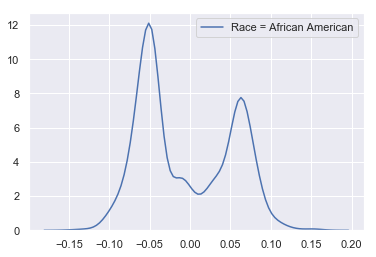

In [17]:
sns.kdeplot(shap_values[:, location_afam], label = 'Race = African American')
sns.kdeplot(shap_values[:, location_rand], label = 'Race  = Randomized African American')

pmf_rand =  get_pmf(shap_values[:, location_rand])
pmf_orig =  get_pmf(shap_values[:, location_afam])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

0.05324022293968647
0.010292553468839389


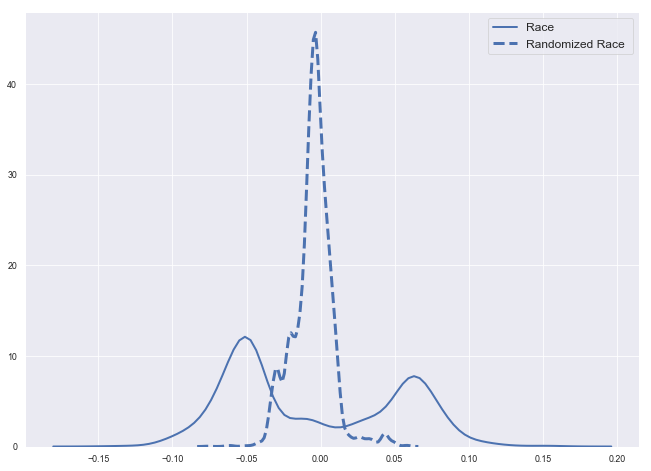

In [50]:
plt.figure(figsize = (11,8))
sns.kdeplot(shap_values[:, location_afam], label = 'Race ', color = 'b', linewidth =2)
print(np.mean(np.abs(shap_values[:, location_afam])))
print(np.mean(np.abs(shap_values_random[:, location_afam])))

sns.kdeplot(shap_values_random[:, location_afam], label = 'Randomized Race ', color = 'b', linestyle = '--', linewidth = 3)
plt.legend(loc='best', prop={'size': 12})

#print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

# Demographic Parity

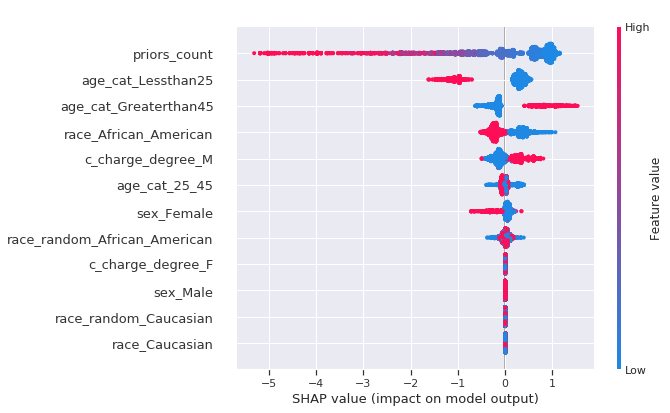

In [0]:
sns.set()
shap.summary_plot(shap_values, X)

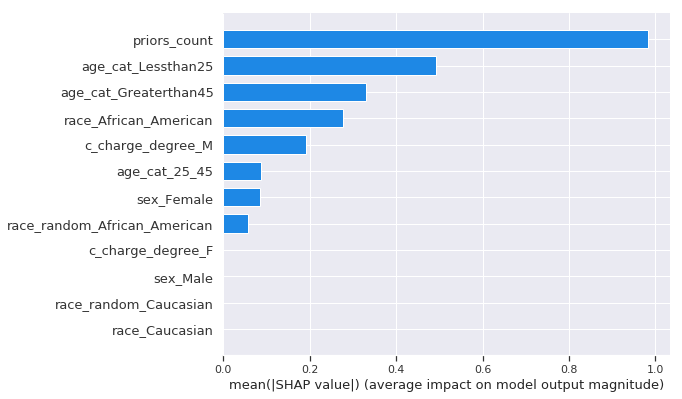

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

# Separation or Equalized Odds

In [23]:
# X_set =  X.iloc[Y_0_AF]
# shap_values_set =  explainer.shap_values(X_set)
# #shap.summary_plot(shap_values_set, X_set, sort = False)
# y_0_afam_values =  shap_values_set[:, locations_interested]
# #plt.hist(tpr_val, bins = 20)


# X_set =  X.iloc[Y_0_C]
# shap_values_set =  explainer.shap_values(X_set)
# #shap.summary_plot(shap_values_set, X_set, sort = False)
# y_0_caucasian_values =  shap_values_set[:, locations_interested]
# #plt.hist(tpr_val, bins = 20)

# X_set =  X.iloc[Y_0_AF_random]
# shap_values_set =  explainer.shap_values(X_set)
# #shap.summary_plot(shap_values_set, X_set, sort = False)
# y_0_afam_random_values =  shap_values_set[:, locations_interested]
# #plt.hist(tpr_val, bins = 20)


# X_set =  X.iloc[Y_0_C_random]
# shap_values_set =  explainer.shap_values(X_set)
# #shap.summary_plot(shap_values_set, X_set, sort = False)
# y_0_caucasian_random_values =  shap_values_set[:, locations_interested]
# #plt.hist(tpr_val, bins = 20)

y_0_afam_values =  shap_values[Y_0_AF, location_afam]
y_0_caucasian_values =  shap_values[Y_0_C, location_afam]
y_0_afam_random_values =  shap_values_random[Y_0_AF_random, location_afam]
y_0_caucasian_random_values =  shap_values_random[Y_0_C_random, location_afam]



wasserstein's distance  for Y==0 0.11507719500631139


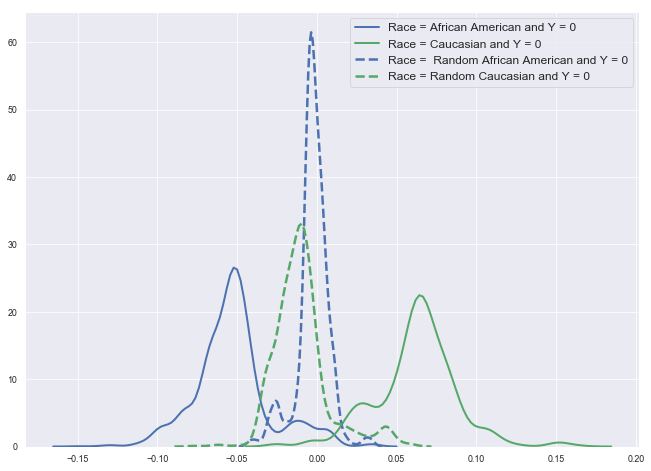

In [42]:
sns.set_context("paper")

plt.figure(figsize = (11,8))

sns.kdeplot(y_0_afam_values, label = 'Race = African American and Y = 0', color = 'b',  linewidth = 2 )
sns.kdeplot(y_0_caucasian_values, label = 'Race = Caucasian and Y = 0', color ='g', linewidth = 2)
sns.kdeplot(y_0_afam_random_values, label = 'Race =  Random African American and Y = 0', color ='b', linewidth = 2.5, linestyle ='--')
sns.kdeplot(y_0_caucasian_random_values, label = 'Race = Random Caucasian and Y = 0', color = 'g', linewidth = 2.5, linestyle ='--')
print("wasserstein's distance  for Y==0", wasserstein_distance(y_0_afam_values,y_0_caucasian_values ))
plt.legend(loc='best', prop={'size': 12})

# pmf_rand =  get_pmf(y_1_afam_values[:,0])
# pmf_orig =  get_pmf(y_1_caucasian_values[:,0])
# print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
# print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

wasserstein's distance  for Y==0 0.010420689799934232


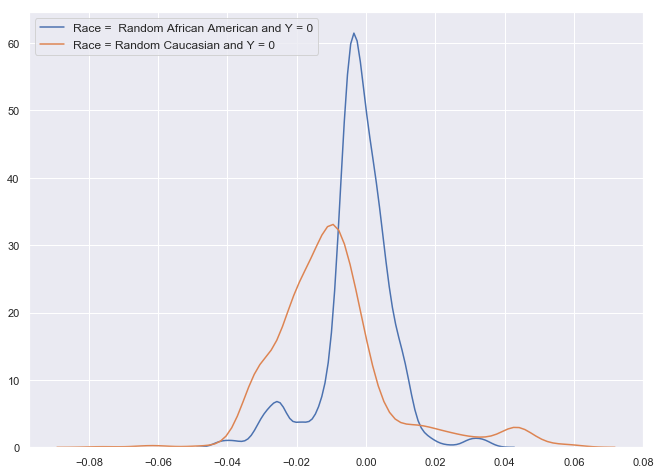

In [21]:
plt.figure(figsize = (11,8))

sns.kdeplot(y_0_afam_random_values, label = 'Race =  Random African American and Y = 0')
sns.kdeplot(y_0_caucasian_random_values, label = 'Race = Random Caucasian and Y = 0')
print("wasserstein's distance  for Y==0", wasserstein_distance(y_0_afam_random_values,y_0_caucasian_random_values ))

plt.legend(loc=2, prop={'size': 12})

# Equality of Opportunity

In [37]:
# X_set =  X.iloc[Y_1_AF]
# shap_values_set =  explainer.shap_values(X_set)
# #shap.summary_plot(shap_values_set, X_set, sort = False)
# y_1_afam_values =  shap_values_set[:, locations_interested]
# #plt.hist(tpr_val, bins = 20)


# X_set =  X.iloc[Y_1_C]
# shap_values_set =  explainer.shap_values(X_set)
# #shap.summary_plot(shap_values_set, X_set, sort = False)
# y_1_caucasian_values =  shap_values_set[:, locations_interested]
# #plt.hist(tpr_val, bins = 20)

# X_set =  X.iloc[Y_1_AF_random]
# shap_values_set =  explainer.shap_values(X_set)
# #shap.summary_plot(shap_values_set, X_set, sort = False)
# y_1_afam_random_values =  shap_values_set[:, locations_interested]
# #plt.hist(tpr_val, bins = 20)


# X_set =  X.iloc[Y_1_C_random]
# shap_values_set =  explainer.shap_values(X_set)
# #shap.summary_plot(shap_values_set, X_set, sort = False)
# y_1_caucasian_random_values =  shap_values_set[:, locations_interested]
# #plt.hist(tpr_val, bins = 20)

y_1_afam_values =  shap_values[Y_1_AF, location_afam]
y_1_caucasian_values =  shap_values[Y_1_C, location_afam]
y_1_afam_random_values =  shap_values_random[Y_1_AF_random, location_afam]
y_1_caucasian_random_values =  shap_values_random[Y_1_C_random, location_afam]


wasserstein's distance  for Y==1 0.10037652115140139


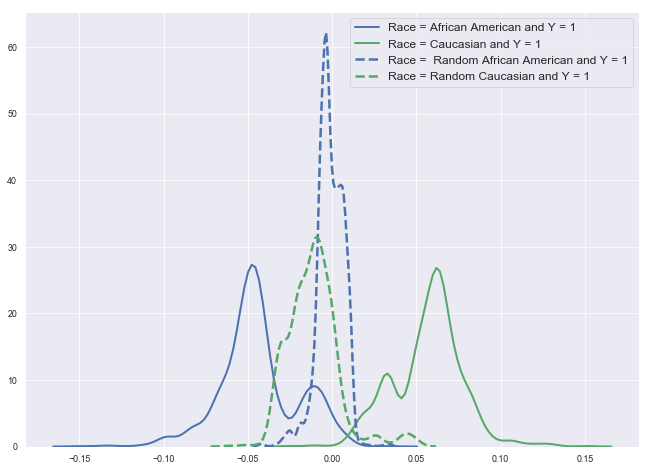

In [47]:
sns.set_context("paper")

plt.figure(figsize = (11,8))

sns.kdeplot(y_1_afam_values, label = 'Race = African American and Y = 1',color = 'b',  linewidth = 2)
sns.kdeplot(y_1_caucasian_values, label = 'Race = Caucasian and Y = 1', color = 'g',  linewidth = 2)
sns.kdeplot(y_1_afam_random_values, label = 'Race =  Random African American and Y = 1', color = 'b',  linewidth = 2.5, linestyle ='--')
sns.kdeplot(y_1_caucasian_random_values, label = 'Race = Random Caucasian and Y = 1',color = 'g',  linewidth = 2.5, linestyle ='--')

print("wasserstein's distance  for Y==1", wasserstein_distance(y_1_afam_values,y_1_caucasian_values ))
plt.legend(loc='best', prop={'size': 12})

# pmf_rand =  get_pmf(y_1_afam_values[:,0])
# pmf_orig =  get_pmf(y_1_caucasian_values[:,0])
# print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
# print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

wasserstein's distance  for Y==1 0.012231491126593167


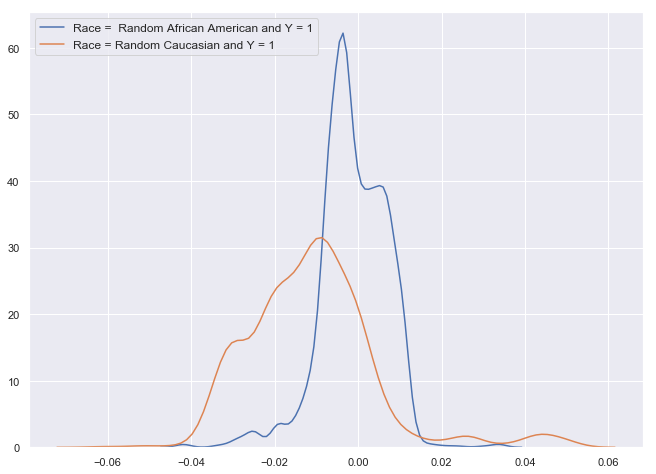

In [123]:
plt.figure(figsize = (11,8))

sns.kdeplot(y_1_afam_random_values, label = 'Race =  Random African American and Y = 1')
sns.kdeplot(y_1_caucasian_random_values, label = 'Race = Random Caucasian and Y = 1')
print("wasserstein's distance  for Y==1", wasserstein_distance(y_1_afam_random_values,y_1_caucasian_random_values ))

plt.legend(loc=2, prop={'size': 12})

In [0]:
sns.kdeplot(y_1_afam_random_values[:,0], label = 'Race = Random African American and Y = 1')
sns.kdeplot(y_1_caucasian_random_values[:,0], label = 'Race = Random Caucasian and Y = 1')
pmf_rand =  get_pmf(y_1_afam_random_values[:,0])
pmf_orig =  get_pmf(y_1_caucasian_random_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

In [0]:
y_1 = pd.Index.union(tp_indices, fn_indices)
X_set =  X.iloc[y_1]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)
shap.summary_plot(shap_values_set, X_set, plot_type="bar")


# Suffciency

#### Get SHAP Values

In [0]:
print("Start working on Sufficiency")
Y_1_AF =  data_final[(data_final['is_recid']==0) & (data_final['race_African_American']==1)].index
Y_0_AF =  data_final[(data_final['is_recid']==1) & (data_final['race_African_American']==1)].index
X_set_Y_1_AF =  X.iloc[Y_1_AF]
X_set_Y_0_AF =  X.iloc[Y_0_AF]

AF =  data_final[(data_final['race_African_American']==1)].index
shap_values_set_Y_1_AF =  explainer.shap_values(X_set_Y_1_AF)
shap_values_set_Y_0_AF =  explainer.shap_values(X_set_Y_0_AF)

#print(shap_values_set_Y_1_AF)
#shap.summary_plot(shap_values_set_Y_1_AF, X_set_Y_1_AF, sort = False)

#print(shap_values_set_Y_0_AF)
#shap.summary_plot(shap_values_set_Y_0_AF, X_set_Y_0_AF, sort = False)

Y_1_C =  data_final[(data_final['is_recid']==0) & (data_final['race_Caucasian']==1)].index
Y_0_C =  data_final[(data_final['is_recid']==1) & (data_final['race_Caucasian']==1)].index
X_set_Y_1_C =  X.iloc[Y_1_C]
X_set_Y_0_C =  X.iloc[Y_0_C]
C = data_final[(data_final['race_African_American']==0)].index
shap_values_set_Y_1_C =  explainer.shap_values(X_set_Y_1_C)
shap_values_set_Y_0_C =  explainer.shap_values(X_set_Y_0_C)

# print(shap_values_set_Y_1_C)
# shap.summary_plot(shap_values_set_Y_1_C, X_set_Y_1_C, sort = False)

# print(shap_values_set_Y_0_C)
# shap.summary_plot(shap_values_set_Y_0_C, X_set_Y_0_C, sort = False)

#shap.summary_plot(shap_values_set, X_set, sort = False)

independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25', 'race_African_American',
       'race_Caucasian','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']


X =  data_final.loc[:, independent_columns]
location_afam  =  X.columns.get_loc("race_African_American")
# Get the race SHAP values for AFAM and Caucasian
y_1_afam_values =  shap_values_set_Y_1_AF[:, [location_afam]]
print(len(y_1_afam_values))
y_0_afam_values =  shap_values_set_Y_0_AF[:, [location_afam]]
print(len(y_0_afam_values))
y_1_c_values =  shap_values_set_Y_1_C[:, [location_afam]]
print(len(y_1_c_values))
y_0_c_values =  shap_values_set_Y_0_C[:, [location_afam]]
print(len(y_0_c_values))

#### Data Overview

In [0]:
# plt.hist(y_1_afam_values, bins = 20, density=True)
print("African American: ", len(AF))
print("African American that are non-reoffender: ", len(X_set_Y_1_AF))
print("African American that are reoffender: ", len(X_set_Y_0_AF),'\n')
print()

print("Caucasian: ", len(C))
print("Caucasian that are non-reoffender: ", len(X_set_Y_1_C))
print("Caucasian that are reoffender: ", len(X_set_Y_0_C),'\n')

#### Visualization

In [0]:
plt.hist(y_1_afam_values, weights=np.ones(len(y_1_afam_values)) / (len(y_1_afam_values)+len(y_0_afam_values)), bins=20, label=['Race = African American and Y = 1'])
# plt.xlabel('SHAP value')
# plt.ylabel('Percentage')
# plt.show()

plt.hist(y_1_c_values, weights=np.ones(len(y_1_c_values)) / (len(y_1_c_values)+len(y_0_c_values)), bins=20, label=['Race = Caucasian and Y = 1'])
plt.title('Sufficency Fairness Criterion')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 / Total People in Race')
plt.ylim(0, 0.25)
plt.legend()
plt.show()

bin_count = 6

plt.hist([y_1_afam_values,y_0_afam_values], bins=bin_count, label=['Y=1','Y=0'])
plt.title('SHAP Count for African American')
plt.xlabel('SHAP value')
plt.ylabel('Count')
plt.legend()
plt.show()



plt.hist([y_1_c_values,y_0_c_values], bins=bin_count, label=['Y=1','Y=0'])
plt.title('SHAP Count for Caucasian')
plt.xlabel('SHAP value')
plt.ylabel('Count')
plt.legend()
plt.show()



hist_afam1, bin_edges_afam1 = np.histogram(y_1_afam_values.ravel(), bins=bin_count)
hist_afam0, bin_edges_afam0 = np.histogram(y_0_afam_values.ravel(), bins=bin_count)
afam1_bindiv_result = np.divide(hist_afam1, np.add(hist_afam1,hist_afam0))

print(hist_afam1)
print(np.add(hist_afam1,hist_afam0))
print(afam1_bindiv_result)

hist_c1, bin_edges_c1 = np.histogram(y_1_c_values.ravel(), bins=bin_count)
hist_c0, bin_edges_c0 = np.histogram(y_0_c_values.ravel(), bins=bin_count)
c1_bindiv_result = np.divide(hist_c1, np.add(hist_c1,hist_c0))

print(hist_c1)
print(np.add(hist_c1,hist_c0))
print(c1_bindiv_result)

min_edge=min(min(bin_edges_afam1), min(bin_edges_afam0))
max_edge=max(max(bin_edges_afam1), max(bin_edges_afam0))
print('AFAM Bins: ', np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), afam1_bindiv_result, label='Y=1 AFAM Percentage',width=0.08, align='center')

plt.title('Sufficency Fairness Criterion')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.legend()

min_edge=min(min(bin_edges_c1), min(bin_edges_c0))
max_edge=max(max(bin_edges_c1), max(bin_edges_c0))
print('CAU Bins: ', np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), c1_bindiv_result, label='Y=1 Caucasian Percentage',width=0.08, align='center')

plt.legend()

plt.show()


min_edge = -0.6
max_edge = 1.0
bin_count = 10
bins=np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count)
hist_afam1, bin_edges_afam1 = np.histogram(y_1_afam_values.ravel(), bins=bins)
hist_afam0, bin_edges_afam0 = np.histogram(y_0_afam_values.ravel(), bins=bins)
afam1_bindiv_result = np.divide(hist_afam1, np.add(hist_afam1,hist_afam0))

hist_c1, bin_edges_c1 = np.histogram(y_1_c_values.ravel(), bins=bins)
hist_c0, bin_edges_c0 = np.histogram(y_0_c_values.ravel(), bins=bins)
c1_bindiv_result = np.divide(hist_c1, np.add(hist_c1,hist_c0))

print('Count Y=1: ', hist_afam1)
print('Count Total: ', np.add(hist_afam1,hist_afam0))
print('Percentage: ', afam1_bindiv_result)
print('Bins: ', np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), '\n')

print('Count Y=1: ', hist_c1)
print('Count Total: ', np.add(hist_c1,hist_c0))
print('Percentage: ', c1_bindiv_result)
print('Bins: ', np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count))

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), afam1_bindiv_result, label='Y=1 AFAM Percentage',width=0.08, align='center')
plt.title('Aligned Sufficency Fairness Criterion')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), c1_bindiv_result, label='Y=1 Caucasian Percentage',width=0.04, align='center')
plt.legend()

plt.show()

# Age Feature
Run the same fairness criteria on the age feature

#### Get SHAP Values

In [0]:
print("Start getting SHAP for Sufficiency - Age")
Y_1_T =  data_final[(data_final['is_recid']==0) & (data_final['age_cat_Lessthan25']==1)].index
Y_0_T =  data_final[(data_final['is_recid']==1) & (data_final['age_cat_Lessthan25']==1)].index
X_set_Y_1_T =  X.iloc[Y_1_T]
X_set_Y_0_T =  X.iloc[Y_0_T]
shap_values_set_Y_1_T =  explainer.shap_values(X_set_Y_1_T)
shap_values_set_Y_0_T =  explainer.shap_values(X_set_Y_0_T)

#print(shap_values_set_Y_1_AF)
#shap.summary_plot(shap_values_set_Y_1_AF, X_set_Y_1_AF, sort = False)

#print(shap_values_set_Y_0_AF)
#shap.summary_plot(shap_values_set_Y_0_AF, X_set_Y_0_AF, sort = False)

Y_1_M =  data_final[(data_final['is_recid']==0) & (data_final['age_cat_25_45']==1)].index
Y_0_M =  data_final[(data_final['is_recid']==1) & (data_final['age_cat_25_45']==1)].index
X_set_Y_1_M =  X.iloc[Y_1_M]
X_set_Y_0_M =  X.iloc[Y_0_M]

shap_values_set_Y_1_M =  explainer.shap_values(X_set_Y_1_M)
shap_values_set_Y_0_M =  explainer.shap_values(X_set_Y_0_M)
# print(shap_values_set_Y_1_M)
# shap.summary_plot(shap_values_set_Y_1_M, X_set_Y_1_M, sort = False)
# print(shap_values_set_Y_0_M)
# shap.summary_plot(shap_values_set_Y_0_M, X_set_Y_0_M, sort = False)

Y_1_S =  data_final[(data_final['is_recid']==0) & (data_final['age_cat_Greaterthan45']==1)].index
Y_0_S =  data_final[(data_final['is_recid']==1) & (data_final['age_cat_Greaterthan45']==1)].index
X_set_Y_1_S =  X.iloc[Y_1_S]
X_set_Y_0_S =  X.iloc[Y_0_S]

shap_values_set_Y_1_S =  explainer.shap_values(X_set_Y_1_S)
shap_values_set_Y_0_S =  explainer.shap_values(X_set_Y_0_S)

#shap.summary_plot(shap_values_set, X_set, sort = False)

In [0]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25', 'race_African_American',
       'race_Caucasian','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']

T =  data_final[(data_final['age_cat_Lessthan25']==1)].index
M = data_final[(data_final['age_cat_25_45']==1)].index
S = data_final[(data_final['age_cat_25_45']==1)].index

X =  data_final.loc[:, independent_columns]
location_T  =  X.columns.get_loc("age_cat_Lessthan25")
location_M  =  X.columns.get_loc("age_cat_25_45")
location_S  =  X.columns.get_loc("age_cat_Greaterthan45")

# Get the race SHAP values for AFAM and Caucasian
y_1_T_values =  shap_values_set_Y_1_T[:, [location_T, location_M, location_S]]
print(len(y_1_T_values))
y_0_T_values =  shap_values_set_Y_0_T[:, [location_T, location_M, location_S]]
print(len(y_0_T_values))
y_1_M_values =  shap_values_set_Y_1_M[:, [location_T, location_M, location_S]]
print(len(y_1_M_values))
y_0_M_values =  shap_values_set_Y_0_M[:, [location_T, location_M, location_S]]
print(len(y_0_M_values))
y_1_S_values =  shap_values_set_Y_1_S[:, [location_T, location_M, location_S]]
print(len(y_1_S_values))
y_0_S_values =  shap_values_set_Y_0_S[:, [location_T, location_M, location_S]]
print(len(y_0_S_values))

# convert 2D SHAP to 1D SHAP
y_0_T_values=y_0_T_values.sum(axis=1)
y_1_T_values=y_1_T_values.sum(axis=1)
y_0_M_values=y_0_M_values.sum(axis=1)
y_1_M_values=y_1_M_values.sum(axis=1)
y_0_S_values=y_0_S_values.sum(axis=1)
y_1_S_values=y_1_S_values.sum(axis=1)

In [0]:
# plt.hist(y_1_afam_values, bins = 20, density=True)
print("Teen: ", len(T))
print("Teen that are non-reoffender: ", len(X_set_Y_1_T))
print("Teen that are reoffender: ", len(X_set_Y_0_T),'\n')
print()

print("Middle Age: ", len(M))
print("Middle Age that are non-reoffender: ", len(X_set_Y_1_M))
print("Middle Age that are reoffender: ", len(X_set_Y_0_M),'\n')

print("Senior: ", len(S))
print("Senior that are non-reoffender: ", len(X_set_Y_1_S))
print("Senior that are reoffender: ", len(X_set_Y_0_S),'\n')

## Equalized Odds

In [0]:

sns.kdeplot(y_0_T_values.ravel(), label = 'Teen and Y=0')
sns.kdeplot(y_0_M_values.ravel(), label = 'Middle Age and Y=0')
sns.kdeplot(y_0_S_values.ravel(), label = 'Senior and Y=0')

## Equalized Opportunity

In [0]:
sns.kdeplot(y_1_T_values.ravel(), label = 'Teen and Y=1')
sns.kdeplot(y_1_M_values.ravel(), label = 'Middle Age and Y=1')
sns.kdeplot(y_1_S_values.ravel(), label = 'Senior and Y=1')

## Sufficiency

In [0]:
plt.hist(y_1_T_values, weights=np.ones(len(y_1_T_values)) / (len(y_1_T_values)+len(y_0_T_values)), bins=20, label=['Age < 25 and Y = 1'])
plt.hist(y_1_M_values, weights=np.ones(len(y_1_M_values)) / (len(y_1_M_values)+len(y_0_M_values)), bins=20, label=['25 < Age < 45 and Y = 1'])
plt.hist(y_1_S_values, weights=np.ones(len(y_1_S_values)) / (len(y_1_S_values)+len(y_0_S_values)), bins=20, label=['Age > 45 and Y = 1'])
plt.title('Overall SHAP for Age Groups')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 / Total People in Age Group')
# plt.ylim(0, 0.25)
plt.legend()
plt.show()

# Figure 2
bin_count = 10
hist_t1, bin_edges_t1 = np.histogram(y_1_T_values.ravel(), bins=bin_count)
hist_t0, bin_edges_t0 = np.histogram(y_0_T_values.ravel(), bins=bin_count)
t1_bindiv_result = np.divide(hist_t1, np.add(hist_t1,hist_t0))

hist_m1, bin_edges_m1 = np.histogram(y_1_M_values.ravel(), bins=bin_count)
hist_m0, bin_edges_m0 = np.histogram(y_0_M_values.ravel(), bins=bin_count)
m1_bindiv_result = np.divide(hist_m1, np.add(hist_m1,hist_m0))

hist_s1, bin_edges_s1 = np.histogram(y_1_S_values.ravel(), bins=bin_count)
hist_s0, bin_edges_s0 = np.histogram(y_0_S_values.ravel(), bins=bin_count)
s1_bindiv_result = np.divide(hist_s1, np.add(hist_s1,hist_s0))

min_edge=min(min(bin_edges_t1), min(bin_edges_t0))
max_edge=max(max(bin_edges_t1), max(bin_edges_t0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), t1_bindiv_result, label='Y=1 Teen Percentage',width=0.05, align='center')
plt.legend()

min_edge=min(min(bin_edges_m1), min(bin_edges_m0))
max_edge=max(max(bin_edges_m1), max(bin_edges_m0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), m1_bindiv_result, label='Y=1 Middle Age Percentage',width=0.05, align='center')
plt.legend()

min_edge=min(min(bin_edges_s1), min(bin_edges_s0))
max_edge=max(max(bin_edges_s1), max(bin_edges_s0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), s1_bindiv_result, label='Y=1 Senior Percentage',width=0.05, align='center')
plt.legend()

plt.title('Sufficency Fairness Criterion - Actual Bin')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.show()

# Figure 5
min_edge = -2
max_edge = 2
bin_count = 20
bins=np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count)
hist_t1, bin_edges_t1 = np.histogram(y_1_T_values.ravel(), bins=bins)
hist_t0, bin_edges_t0 = np.histogram(y_0_T_values.ravel(), bins=bins)
t1_bindiv_result = np.divide(hist_t1, np.add(hist_t1,hist_t0))

hist_m1, bin_edges_m1 = np.histogram(y_1_M_values.ravel(), bins=bins)
hist_m0, bin_edges_m0 = np.histogram(y_0_M_values.ravel(), bins=bins)
m1_bindiv_result = np.divide(hist_m1, np.add(hist_m1,hist_m0))

hist_s1, bin_edges_s1 = np.histogram(y_1_S_values.ravel(), bins=bins)
hist_s0, bin_edges_s0 = np.histogram(y_0_S_values.ravel(), bins=bins)
s1_bindiv_result = np.divide(hist_s1, np.add(hist_s1,hist_s0))

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), t1_bindiv_result, label='Y=1 Teen %',width=0.05, align='center')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), m1_bindiv_result, label='Y=1 Middle Age %',width=0.05, align='center')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), s1_bindiv_result, label='Y=1 Senior %',width=0.05, align='center')
plt.legend()


plt.title('Sufficency Fairness Criterion for Age - Aligned Bin')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.show()


# Age Feature Randomized
Run the same fairness criteria on the randomized age feature

In [0]:
# data_final.info()
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F', 'age_random_25_45', 'age_random_Greaterthan45', 'age_random_Lessthan25']


X =  data_final.loc[:, independent_columns]
y =  data_final['Low']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
data_final['pred'] = model.predict(xgb_full)

fpr, tpr , thresholds = roc_curve(data_final['Low'], data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

explainer = shap.TreeExplainer(model)
shap_values =  explainer.shap_values(X)

In [0]:
print("Start getting SHAP for Sufficiency - Randomized Age")
Y_1_T =  data_final[(data_final['is_recid']==0) & (data_final['age_random_Lessthan25']==1)].index
Y_0_T =  data_final[(data_final['is_recid']==1) & (data_final['age_random_Lessthan25']==1)].index
X_set_Y_1_T =  X.iloc[Y_1_T]
X_set_Y_0_T =  X.iloc[Y_0_T]
shap_values_set_Y_1_T =  explainer.shap_values(X_set_Y_1_T)
shap_values_set_Y_0_T =  explainer.shap_values(X_set_Y_0_T)
print('SHAP for Teen: ', shap_values_set_Y_1_T.shape)
#shap.summary_plot(shap_values_set_Y_1_AF, X_set_Y_1_AF, sort = False)

#print(shap_values_set_Y_0_AF)
#shap.summary_plot(shap_values_set_Y_0_AF, X_set_Y_0_AF, sort = False)

Y_1_M =  data_final[(data_final['is_recid']==0) & (data_final['age_random_25_45']==1)].index
Y_0_M =  data_final[(data_final['is_recid']==1) & (data_final['age_random_25_45']==1)].index
X_set_Y_1_M =  X.iloc[Y_1_M]
X_set_Y_0_M =  X.iloc[Y_0_M]

shap_values_set_Y_1_M =  explainer.shap_values(X_set_Y_1_M)
shap_values_set_Y_0_M =  explainer.shap_values(X_set_Y_0_M)
print('SHAP for Middle Age: ', shap_values_set_Y_1_T.shape)
# print(shap_values_set_Y_1_M)
# shap.summary_plot(shap_values_set_Y_1_M, X_set_Y_1_M, sort = False)
# print(shap_values_set_Y_0_M)
# shap.summary_plot(shap_values_set_Y_0_M, X_set_Y_0_M, sort = False)

Y_1_S =  data_final[(data_final['is_recid']==0) & (data_final['age_random_Greaterthan45']==1)].index
Y_0_S =  data_final[(data_final['is_recid']==1) & (data_final['age_random_Greaterthan45']==1)].index
X_set_Y_1_S =  X.iloc[Y_1_S]
X_set_Y_0_S =  X.iloc[Y_0_S]

shap_values_set_Y_1_S =  explainer.shap_values(X_set_Y_1_S)
shap_values_set_Y_0_S =  explainer.shap_values(X_set_Y_0_S)
print('SHAP for Senior: ', shap_values_set_Y_1_T.shape)

#shap.summary_plot(shap_values_set, X_set, sort = False)

In [0]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25','race_random_African_American',
       'race_random_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F', 'age_random_25_45', 'age_random_Greaterthan45', 'age_random_Lessthan25']
T =  data_final[(data_final['age_random_Lessthan25']==1)].index
M = data_final[(data_final['age_random_25_45']==1)].index
S = data_final[(data_final['age_random_Greaterthan45']==1)].index

print(shap_values_set_Y_1_T.shape)

X =  data_final.loc[:, independent_columns]
location_T  =  X.columns.get_loc("age_random_Lessthan25")
location_M  =  X.columns.get_loc("age_random_25_45")
location_S  =  X.columns.get_loc("age_random_Greaterthan45")

# Get the race SHAP values for Age Groups
y_1_T_values =  shap_values_set_Y_1_T[:, [location_T, location_M, location_S]]
print(len(y_1_T_values))
y_0_T_values =  shap_values_set_Y_0_T[:, [location_T, location_M, location_S]]
print(len(y_0_T_values))
y_1_M_values =  shap_values_set_Y_1_M[:, [location_T, location_M, location_S]]
print(len(y_1_M_values))
y_0_M_values =  shap_values_set_Y_0_M[:, [location_T, location_M, location_S]]
print(len(y_0_M_values))
y_1_S_values =  shap_values_set_Y_1_S[:, [location_T, location_M, location_S]]
print(len(y_1_S_values))
y_0_S_values =  shap_values_set_Y_0_S[:, [location_T, location_M, location_S]]
print(len(y_0_S_values))

# convert 2D SHAP to 1D SHAP
y_0_T_values=y_0_T_values.sum(axis=1)
y_1_T_values=y_1_T_values.sum(axis=1)
y_0_M_values=y_0_M_values.sum(axis=1)
y_1_M_values=y_1_M_values.sum(axis=1)
y_0_S_values=y_0_S_values.sum(axis=1)
y_1_S_values=y_1_S_values.sum(axis=1)

#### Equalized Odds

In [0]:
sns.kdeplot(y_0_T_values.ravel(), label = 'Teen and Y=0')
sns.kdeplot(y_0_M_values.ravel(), label = 'Middle Age and Y=0')
sns.kdeplot(y_0_S_values.ravel(), label = 'Senior and Y=0')

#### Equalized Opportunities

In [0]:
sns.kdeplot(y_1_T_values.ravel(), label = 'Teen and Y=1')
sns.kdeplot(y_1_M_values.ravel(), label = 'Middle Age and Y=1')
sns.kdeplot(y_1_S_values.ravel(), label = 'Senior and Y=1')

#### Sufficiency

In [0]:
plt.hist(y_1_T_values, weights=np.ones(len(y_1_T_values)) / (len(y_1_T_values)+len(y_0_T_values)), bins=20, label=['Age < 25 and Y = 1'])
plt.hist(y_1_M_values, weights=np.ones(len(y_1_M_values)) / (len(y_1_M_values)+len(y_0_M_values)), bins=20, label=['25 < Age < 45 and Y = 1'])
plt.hist(y_1_S_values, weights=np.ones(len(y_1_S_values)) / (len(y_1_S_values)+len(y_0_S_values)), bins=20, label=['Age > 45 and Y = 1'])
plt.title('Overall SHAP for Age Groups')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 / Total People in Age Group')
# plt.ylim(0, 0.25)
plt.legend()
plt.show()

# Figure 2
bin_count = 10
hist_t1, bin_edges_t1 = np.histogram(y_1_T_values.ravel(), bins=bin_count)
hist_t0, bin_edges_t0 = np.histogram(y_0_T_values.ravel(), bins=bin_count)
t1_bindiv_result = np.divide(hist_t1, np.add(hist_t1,hist_t0))

hist_m1, bin_edges_m1 = np.histogram(y_1_M_values.ravel(), bins=bin_count)
hist_m0, bin_edges_m0 = np.histogram(y_0_M_values.ravel(), bins=bin_count)
m1_bindiv_result = np.divide(hist_m1, np.add(hist_m1,hist_m0))

hist_s1, bin_edges_s1 = np.histogram(y_1_S_values.ravel(), bins=bin_count)
hist_s0, bin_edges_s0 = np.histogram(y_0_S_values.ravel(), bins=bin_count)
s1_bindiv_result = np.divide(hist_s1, np.add(hist_s1,hist_s0))

min_edge=min(min(bin_edges_t1), min(bin_edges_t0))
max_edge=max(max(bin_edges_t1), max(bin_edges_t0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), t1_bindiv_result, label='Y=1 Teen Percentage',width=0.05, align='center')
plt.legend()

min_edge=min(min(bin_edges_m1), min(bin_edges_m0))
max_edge=max(max(bin_edges_m1), max(bin_edges_m0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), m1_bindiv_result, label='Y=1 Middle Age Percentage',width=0.05, align='center')
plt.legend()

min_edge=min(min(bin_edges_s1), min(bin_edges_s0))
max_edge=max(max(bin_edges_s1), max(bin_edges_s0))
plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count), s1_bindiv_result, label='Y=1 Senior Percentage',width=0.05, align='center')
plt.legend()

plt.title('Sufficency Fairness Criterion - Actual Bin')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.show()

# Figure 5
min_edge = -2
max_edge = 2
bin_count = 20
bins=np.arange(min_edge, max_edge, (max_edge-min_edge)/bin_count)
hist_t1, bin_edges_t1 = np.histogram(y_1_T_values.ravel(), bins=bins)
hist_t0, bin_edges_t0 = np.histogram(y_0_T_values.ravel(), bins=bins)
t1_bindiv_result = np.divide(hist_t1, np.add(hist_t1,hist_t0))

hist_m1, bin_edges_m1 = np.histogram(y_1_M_values.ravel(), bins=bins)
hist_m0, bin_edges_m0 = np.histogram(y_0_M_values.ravel(), bins=bins)
m1_bindiv_result = np.divide(hist_m1, np.add(hist_m1,hist_m0))

hist_s1, bin_edges_s1 = np.histogram(y_1_S_values.ravel(), bins=bins)
hist_s0, bin_edges_s0 = np.histogram(y_0_S_values.ravel(), bins=bins)
s1_bindiv_result = np.divide(hist_s1, np.add(hist_s1,hist_s0))

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), t1_bindiv_result, label='Y=1 Teen %',width=0.1, align='center')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), m1_bindiv_result, label='Y=1 Middle Age %',width=0.05, align='center')
plt.legend()

plt.bar(np.arange(min_edge, max_edge, (max_edge-min_edge)/(bin_count-1)), s1_bindiv_result, label='Y=1 Senior %',width=0.02, align='center')
plt.legend()


plt.title('Sufficency Fairness Criterion for Age - Aligned Bin')
plt.xlabel('SHAP value')
plt.ylabel('Y=1 in bin / Y=0,1 in bin')
plt.show()


# Recourse using Explanations  model training
Code taken from the paper fairness and calibrations and modified

Things to do. 
1. Look at two post processing techniques. Equlized Odds and Calibrated equalized odds
2. Define a metric to come up with a better recourse solution

In [0]:
independent_columns  = ['priors_count','age_cat_25_45', 'age_cat_Greaterthan45',
       'age_cat_Lessthan25', 'race_African_American',
       'race_Caucasian',
       'sex_Female', 'sex_Male', 'c_charge_degree_M','c_charge_degree_F']

# 'race_random_African_American',
#        'race_random_Caucasian',
X =  data_final.loc[:, independent_columns]
data_final['outcome'] =  1 - data_final['is_recid']
y =  data_final['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"logloss",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model_calibrated = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="logloss" , num_boost_round=10)
data_final['pred'] = model_calibrated.predict (xgb_full)


#locations_interested = [location_afam,location_caucasian, location_rand]


[0]	test-logloss:0.692829
[1000]	test-logloss:0.598657
[2000]	test-logloss:0.590031
[3000]	test-logloss:0.586955
[4000]	test-logloss:0.585007
[5000]	test-logloss:0.58363
[6000]	test-logloss:0.58234
[7000]	test-logloss:0.581483
[8000]	test-logloss:0.580824
[9000]	test-logloss:0.57998
[9999]	test-logloss:0.579343


In [0]:
shap_file_name="shap_probability_values.csv" 

try:  
  print("Shap Values file found")
  shap_values =  pd.read_csv(shap_file_name).values
except:
  print("Shap Values file not found")

  background = sklearn.utils.resample(X, n_samples=100, replace=True)
  explainer = shap.TreeExplainer(model_calibrated ,background, feature_dependence = 'independent', model_output = 'probability')
  shap_values =  explainer.shap_values(X)
  shap_df1 = pd.DataFrame(shap_values, columns=independent_columns)
  shap_df1.to_csv(shap_file_name, index = False)
finally:
  
  print(shap_values)


race_afam = data_final[(data_final['race_African_American']==1)].index

race_caucasian = data_final[(data_final['race_African_American']==0)].index


print("Number of Caucasian  is " + str(len(race_caucasian)))
print("Number of African American  is " + str(len(race_afam)))


location_afam  =  X.columns.get_loc("race_African_American")
location_caucasian =X.columns.get_loc("race_Caucasian")
location_mis = X.columns.get_loc("c_charge_degree_M")
location_fel = X.columns.get_loc("c_charge_degree_F")


Shap Values file found
[[ 0.16315034 -0.00567695 -0.00903823 ...  0.          0.00059408
   0.        ]
 [-0.14103569 -0.0103211  -0.03979435 ...  0.         -0.02026377
   0.        ]
 [-0.30976403  0.02661651 -0.02146385 ...  0.         -0.00941742
   0.        ]
 ...
 [ 0.18868435 -0.00587414 -0.01243486 ...  0.         -0.00052342
   0.        ]
 [ 0.18868435 -0.00587414 -0.01243486 ...  0.         -0.00052342
   0.        ]
 [-0.09499612 -0.00416244 -0.03347641 ...  0.          0.0406883
   0.        ]]
Number of Caucasian  is 2103
Number of African American  is 3175


In [0]:
shap_df = pd.DataFrame(shap_values, columns =independent_columns)
shap_df.head()

,priors_count,age_cat_25_45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African_American,race_Caucasian,sex_Female,sex_Male,c_charge_degree_M,c_charge_degree_F
0,0.163150,-0.005677,-0.009038,0.031686,-0.001032,0.0,-0.014156,0.0,0.000594,0.0
1,-0.141036,-0.010321,-0.039794,-0.151572,-0.011966,0.0,-0.022313,0.0,-0.020264,0.0
2,-0.309764,0.026617,-0.021464,0.033815,0.057778,0.0,-0.011621,0.0,-0.009417,0.0
3,0.158147,-0.013117,-0.013298,0.020078,0.004213,0.0,0.063042,0.0,0.057022,0.0
4,0.147119,-0.015706,-0.018629,0.029867,0.012154,0.0,0.000470,0.0,-0.010718,0.0


# Extra Code !!! Dont USE

[1.36138506e+01 6.00130028e+00 3.43449614e+00 2.74670751e+00
 1.77393344e+00 1.48947337e+00 8.63597344e-01 2.89064134e-17
 0.00000000e+00 0.00000000e+00]


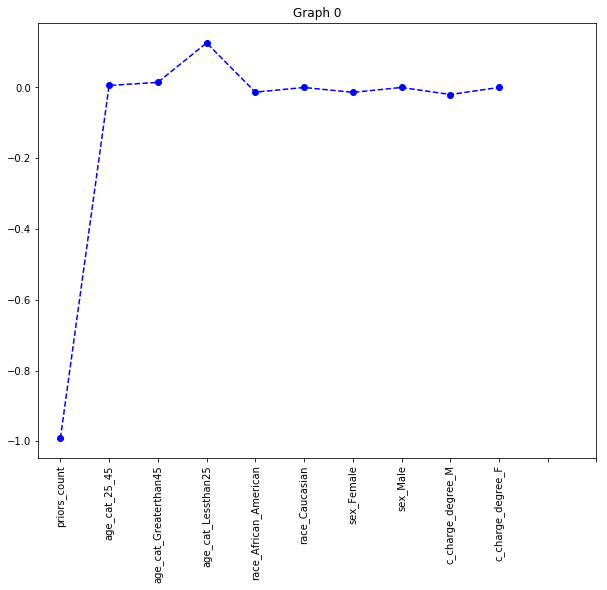

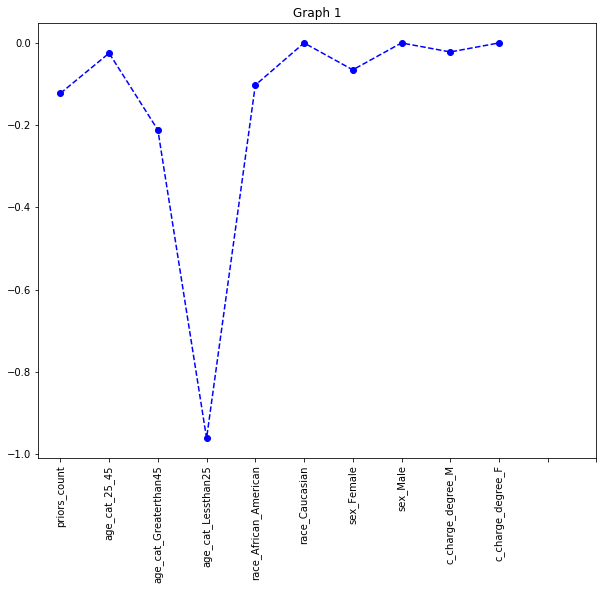

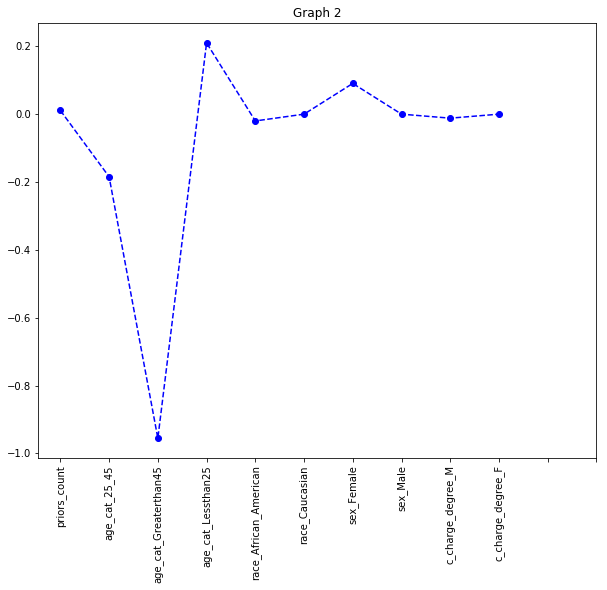

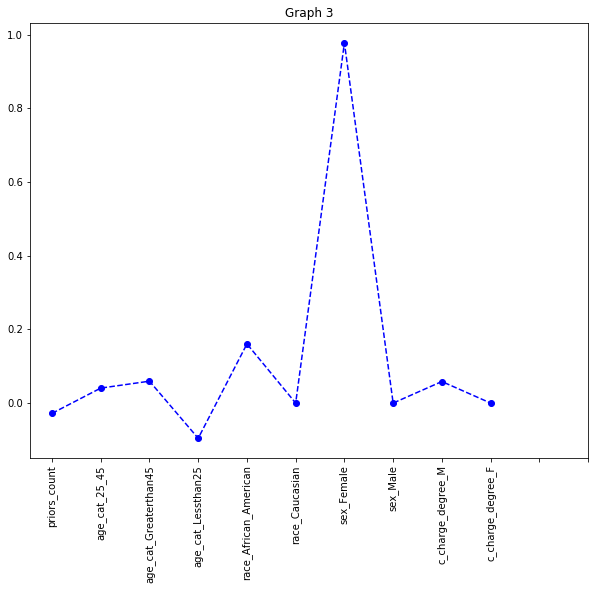

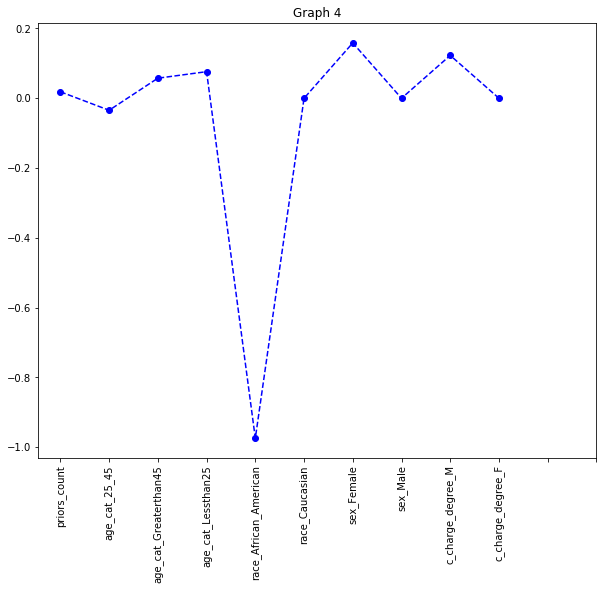

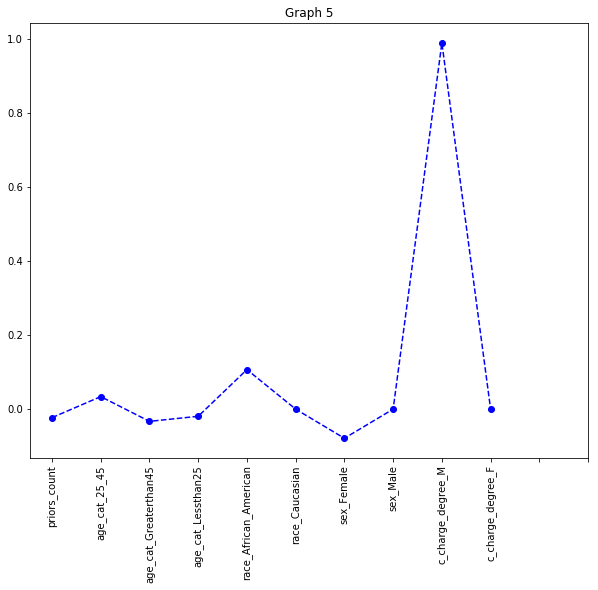

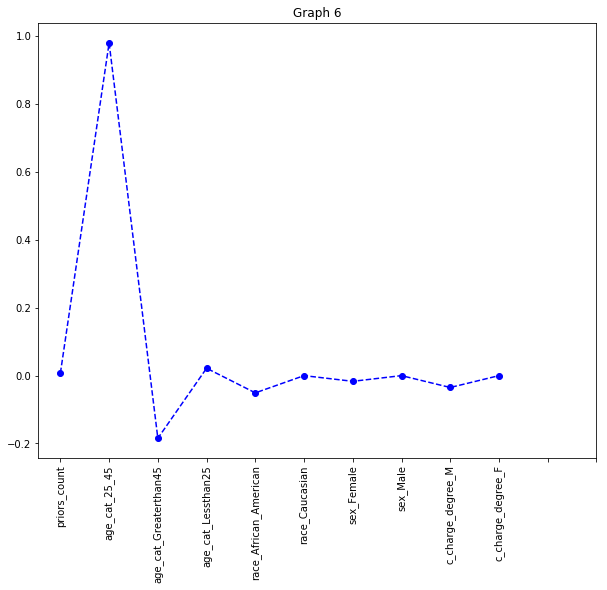

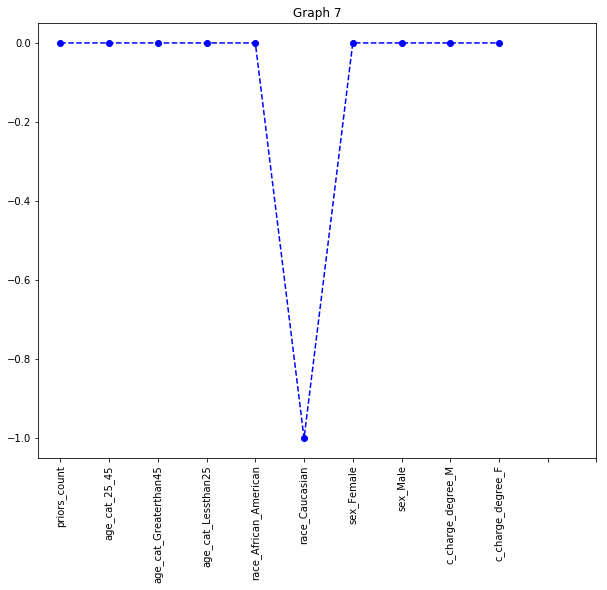

In [0]:
u,s,vh = svd(shap_values, False)
print(s)
for i in range(8):
    plt.figure(figsize=(10,8))
    plt.plot(vh[i],'--bo')
    plt.title('Graph '+ str(i))
    plt.xticks(range(12), X.columns, rotation = 90)
    plt.show()

In [0]:
u[102]

array([-1.15033668e-02, -6.89074156e-03,  7.57557264e-03,  2.11114734e-02,
        9.61903536e-03,  3.21554773e-02, -1.39973476e-02,  6.34635281e-04,
        7.42447421e-04, -4.03856152e-05])

#


In [0]:
sns.kdeplot(y_1_values[race_afam,0], label = 'African American Y = 1')
sns.kdeplot(y_0_values[:,0], label = 'African American Y = 0')

print("Mean value of Y = 1 actual race " + str(np.mean(y_1_values[:,0])))
print("Mean value of Y = 0 actual race " + str(np.mean(y_0_values[:,0])))

print("KL Divergence of the two distributions" + str(np.mean(y_0_values[:,0])))


IndexError: ignored

Mean value of Y = 1 random race 0.009440826
Mean value of Y = 0 random race -0.002954985


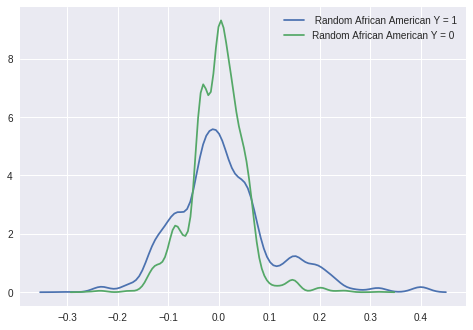

In [0]:
sns.kdeplot(y_1_values[:,2], label = ' Random African American Y = 1')
sns.kdeplot(y_0_values[:,2], label = 'Random African American Y = 0')

print("Mean value of Y = 1 random race " + str(np.mean(y_1_values[:,2])))
print("Mean value of Y = 0 random race " + str(np.mean(y_0_values[:,2])))

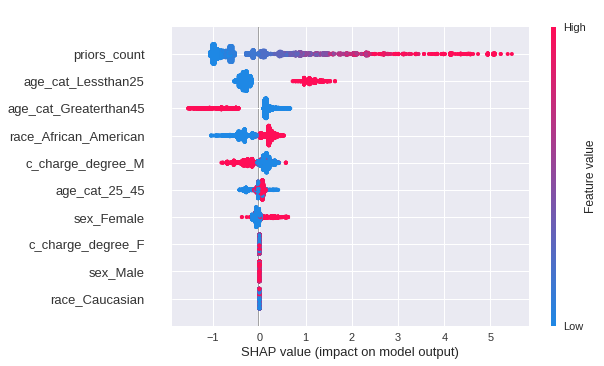

In [0]:
shap.summary_plot(shap_values, X)

In [0]:
race_total = np.sum(shap_values[:, locations_interested], axis = 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[[1.        0.4364914]
 [0.4364914 1.       ]]
[[ 1. nan]
 [nan nan]]
[[1.        0.4364914]
 [0.4364914 1.       ]]


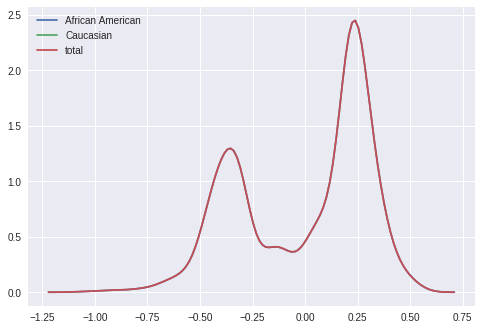

In [0]:
sns.kdeplot(shap_values[:,location_afam], label = 'African American')
sns.kdeplot(shap_values[:,location_caucasian], label = 'Caucasian')
sns.kdeplot(race_total, label = 'total')

print(np.corrcoef(data_final['pred'], shap_values[:,location_afam]))
print(np.corrcoef(data_final['pred'], shap_values[:,location_caucasian]))
print(np.corrcoef(data_final['pred'], race_total))

shap_df = pd.DataFrame(shap_values, columns = independent_columns)



In [0]:
shap_df.head()

,priors_count,age_cat_25_45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African_American,race_Caucasian,race_Hispanic,sex_Female,sex_Male,c_charge_degree_M,c_charge_degree_F
0,-0.885580,0.075000,0.111521,-0.299907,0.231805,0.000128,0.036940,-0.001671,0.0,0.161214,0.0
1,0.693717,0.145984,0.214665,1.102876,0.152156,0.040000,0.005197,-0.044442,0.0,0.046076,0.0
2,3.263394,0.075304,0.579669,-0.193985,-0.585169,-0.397150,0.036854,-0.082842,0.0,0.200138,0.0
3,-0.970377,0.056284,0.186682,-0.448995,-0.231974,0.131869,0.080414,0.244301,0.0,-0.325195,0.0
4,-0.823680,0.084322,0.111674,-0.291066,-0.257937,-0.030508,0.036470,-0.060879,0.0,0.210234,0.0


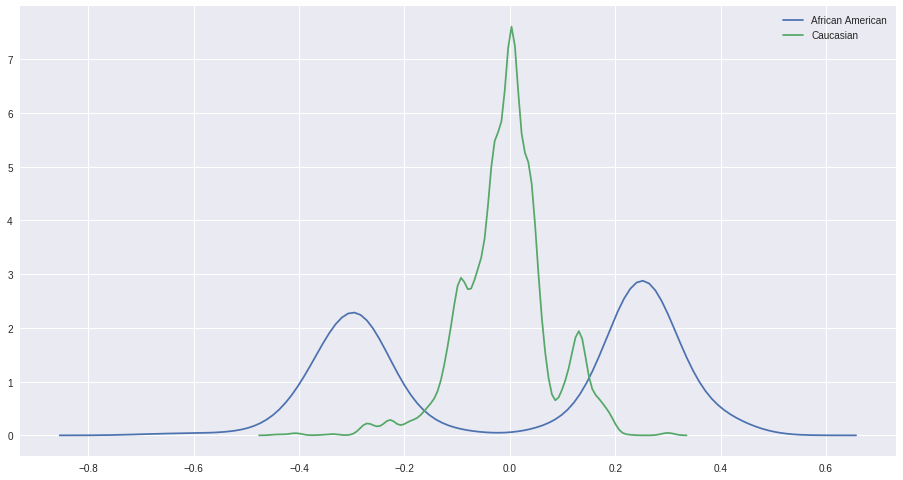

In [0]:
sns.kdeplot(shap_values[:,location_afam], label = 'African American')
sns.kdeplot(shap_values[:,location_caucasian], label = 'Caucasian')


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


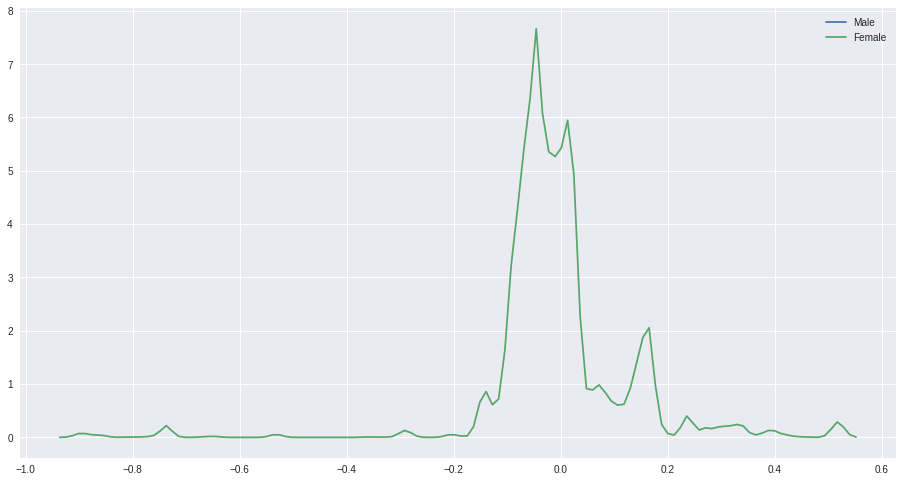

In [0]:
sns.kdeplot(shap_values[:,location_male], label = 'Male')
sns.kdeplot(shap_values[:,location_female], label = 'Female')


The above figure shows the distribution of the SHAP values for two one hot encoded feature vectors representing if the race of the person is African American (blue) or the race is Caucasian (green).  Demographic Parity requires independence between the protected attribute

Possible Analysis Ideas ;
2. Rank of highest positive and negative exaplanations
3. Debisas the system using a fairness algorithm and use shapelye values again

Questions to ask:
1. Defining fairness in terms of explanation. Look at Exposure terms
2. Counterfactual estimation

SHAPLEY TO FAIRNESS TRANFORM


*  Dummy players should get 0 value 
*   Shapley axioms, If i and j are interchangeable, they should get equal values
*  Additivity Cooperative game is sum of values fo both individual games
*   List item




Fairness Definitions

Well calibrated Compas scores


1.  Statistical Bias- Difference between estimators expected value and true value.  Doesnot say anything about for errors or distribution of errors
2.   How Algorithmic Systems Support Human Values


*  Group Fairness - outcome fairness

>   Predictive Parity and different base rates imples equal FPR and FNR cannot be achieved

Different Stakeholders have different interest
Decision Maker = TP/(FP+TP) Predictive Value

Defendant:  FPR = FP /(TN+FP)

Society: Demography 










In [0]:
X_set =  X.iloc[tp_indices]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
#shap.summary_plot(shap_values_set, X_set, plot_type="bar")
tp_val =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)
plt.show()

In [0]:
X_set =  X.iloc[fn_indices]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set)
#shap.summary_plot(shap_values_set, X_set, plot_type="bar")

fn_val =  shap_values_set[:, locations_interested]
#plt.hist(fnr_val, bins = 20)
plt.show()

In [0]:
X_set =  X.iloc[fp_indices]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set)
#shap.summary_plot(shap_values_set, X_set, plot_type="bar")
fp_val =  shap_values_set[:, locations_interested]
#plt.hist(fpr_val, bins = 20)
plt.show()

In [0]:
X_set =  X.iloc[tn_indices]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set)
#shap.summary_plot(shap_values_set, X_set, plot_type="bar")
tn_val =  shap_values_set[:, locations_interested]
#plt.hist(tnr_val, bins = 20)
plt.show()

In [0]:
print(np.corrcoef(data_final['decile_score'], shap_values[:,location_afam]))
print(np.corrcoef(data_final['decile_score'], shap_values[:,location_caucasian]))
print(np.corrcoef(data_final['pred'], shap_values[:,location_afam]))
print(np.corrcoef(data_final['pred'], shap_values[:,location_caucasian]))

[[1.         0.28159559]
 [0.28159559 1.        ]]
[[1.         0.12600542]
 [0.12600542 1.        ]]
[[1.         0.42793318]
 [0.42793318 1.        ]]
[[1.         0.20657408]
 [0.20657408 1.        ]]


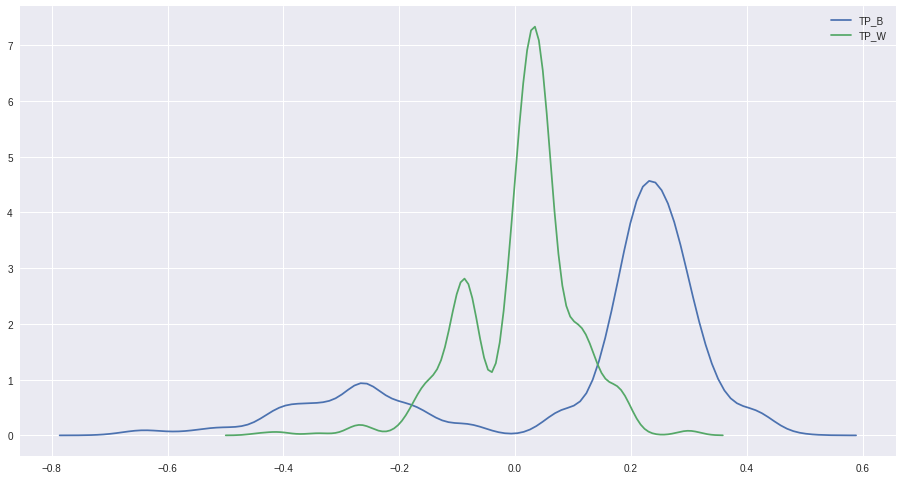

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.kdeplot(tp_val[:,0],label = 'TP_B')
sns.kdeplot(tp_val[:,1],label = 'TP_W')


#sns.kdeplot(fp_val,label = 'FP')
#sns.kdeplot(tn_val,label = 'TN')
# sns.kdeplot(fn_val,label = 'FN')
#plt.legend(['tp','fp','tn', 'fn'], ncol=2, loc='upper left')
plt.show()


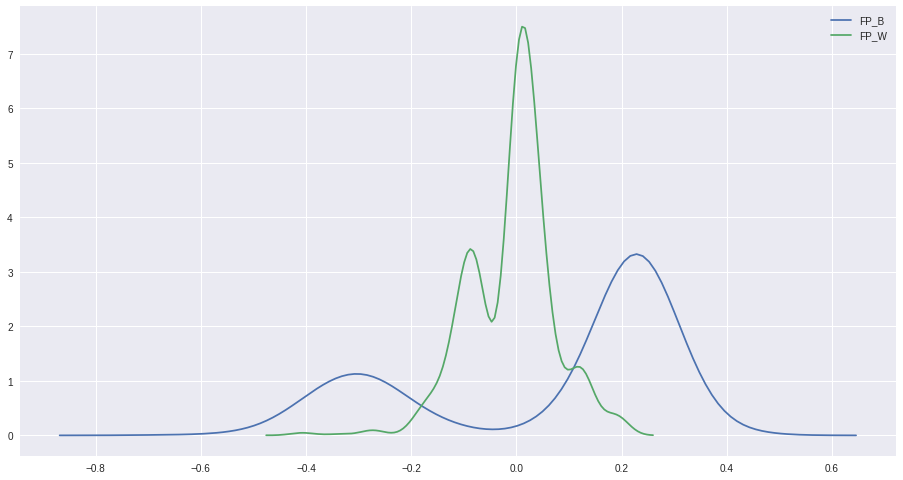

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,8.27)})
#sns.kdeplot(tp_val,label = 'TP')
sns.kdeplot(fp_val[:,0],label = 'FP_B')
sns.kdeplot(fp_val[:,1],label = 'FP_W')

#sns.kdeplot(tn_val,label = 'TN')
#sns.kdeplot(fn_val,label = 'FN')
#plt.legend(['tp','fp','tn', 'fn'], ncol=2, loc='upper left')
plt.show()

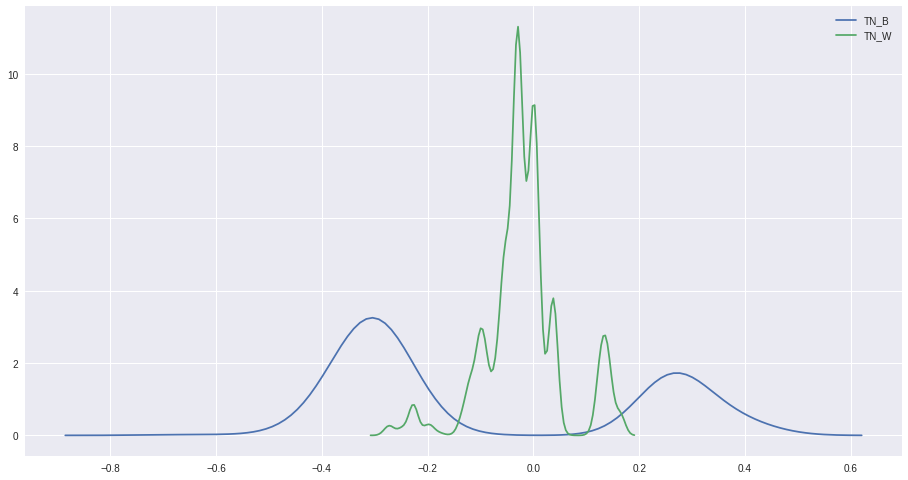

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,8.27)})
#sns.kdeplot(tp_val,label = 'TP')
#sns.kdeplot(fp_val,label = 'FP')
sns.kdeplot(tn_val[:,0],label = 'TN_B')
sns.kdeplot(tn_val[:,1],label = 'TN_W')

#sns.kdeplot(fn_val,label = 'FN')
#plt.legend(['tp','fp','tn', 'fn'], ncol=2, loc='upper left')
plt.show()

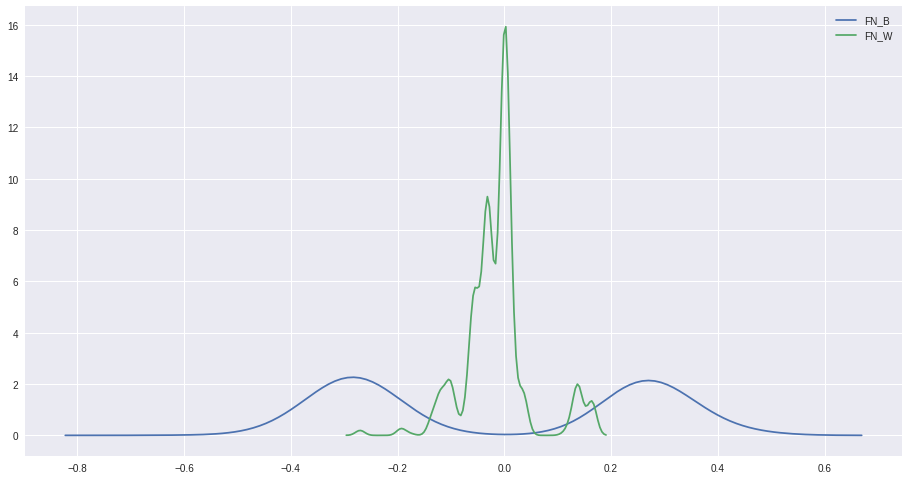

In [0]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,8.27)})
#sns.kdeplot(tp_val,label = 'TP')
#sns.kdeplot(fp_val,label = 'FP')
#sns.kdeplot(tn_val,label = 'TN')
sns.kdeplot(fn_val[:,0],label = 'FN_B')
sns.kdeplot(fn_val[:,1],label = 'FN_W')

#plt.legend(['tp','fp','tn', 'fn'], ncol=2, loc='upper left')
plt.show()

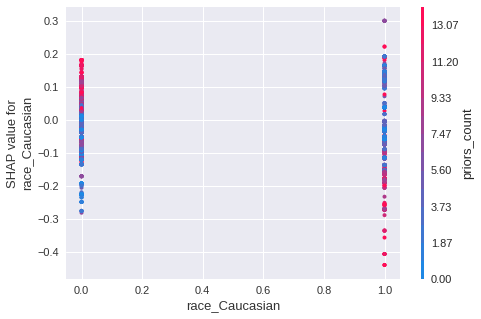

In [0]:

shap.dependence_plot( "race_Caucasian",
    shap_values, X, interaction_index = 'priors_count')




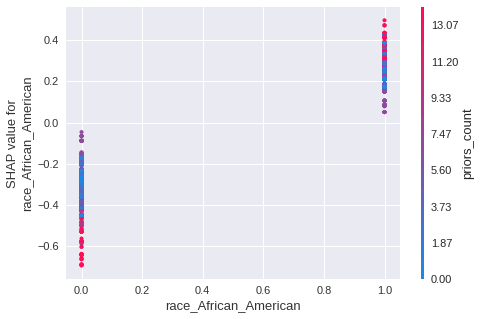

In [0]:

shap.dependence_plot( "race_African_American",
    shap_values, X, interaction_index = 'priors_count')




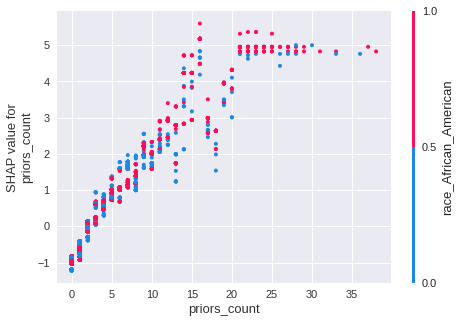

In [0]:

shap.dependence_plot( "priors_count",
    shap_values, X, interaction_index = 'race_African_American')



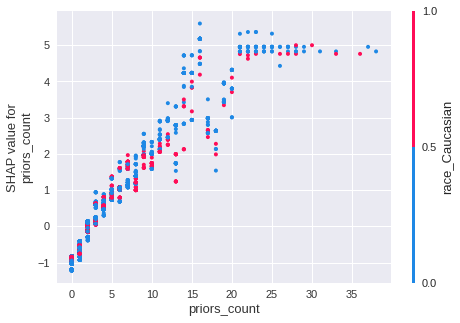

In [0]:
shap.dependence_plot( "priors_count",
    shap_values, X, interaction_index = 'race_Caucasian')


In [0]:
sprshap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:2000,:])

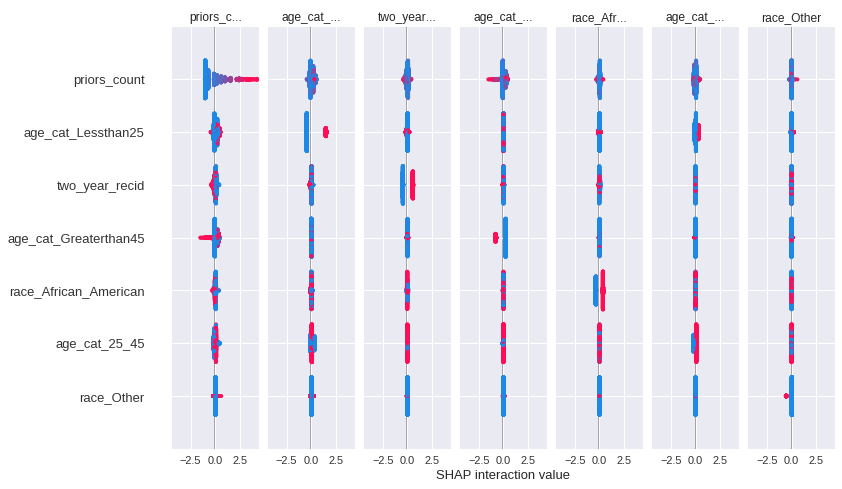

In [0]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

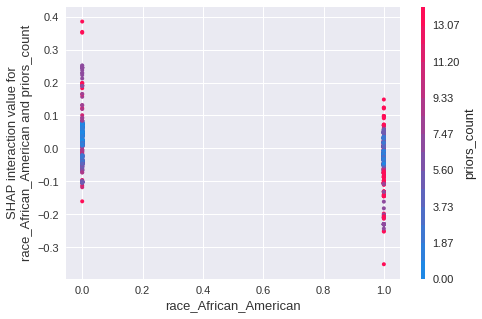

In [0]:


shap.dependence_plot(
    ("race_African_American", "priors_count"),
    shap_interaction_values, X.iloc[:2000,:]
)



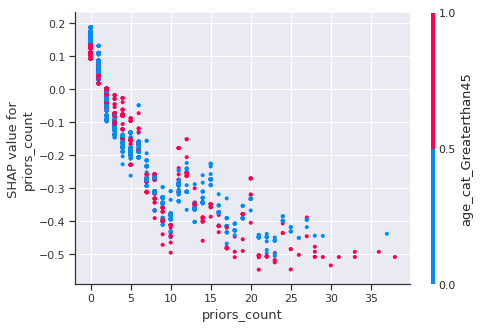

In [0]:
shap.dependence_plot("priors_count", shap_values, X)

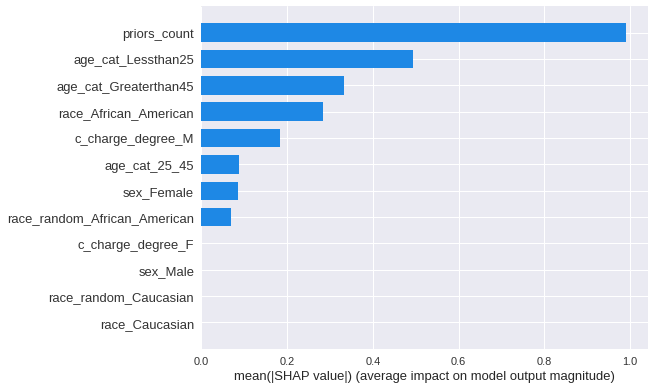

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

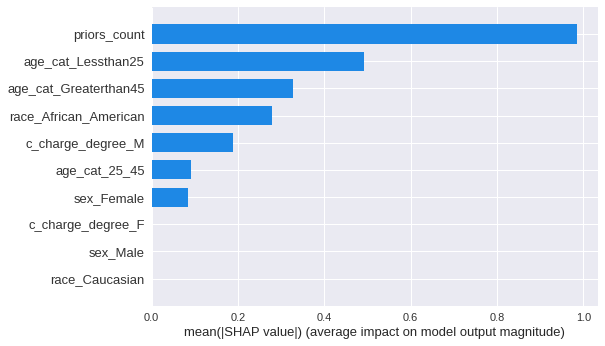

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [0]:
import statsmodels.api as sm

model =  sm.formula.glm("score_factor ~ priors_count + two_year_recid +\
       age_cat_25_45 + age_cat_Greaterthan45 + \
       age_cat_Lessthan25 + race_African_American  + \
       race_Caucasian   + \
       sex_Female + sex_Male" \
      , family =  sm.families.Binomial() , data =  data_final).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Generalized Linear Model Regression Results                                 
=============================================================================================================
Dep. Variable:     ['score_factor[Low]', 'score_factor[MediumHigh]']   No. Observations:                 5278
Model:                                                           GLM   Df Residuals:                     5271
Model Family:                                               Binomial   Df Model:                            6
Link Function:                                                 logit   Scale:                             1.0
Method:                                                         IRLS   Log-Likelihood:                -2718.9
Date:                                               Sun, 31 Mar 2019   Deviance:                       5437.8
Time:                                                       08:18:32   Pearson chi2:                 5.27e+03
No. Iterations:                                                    6                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5585      0.026     21.701      0.000       0.508       0.609
priors_count             -0.2730      0.012    -23.204      0.000      -0.296      -0.250
two_year_recid           -0.7100      0.068    -10.451      0.000      -0.843      -0.577
age_cat_25_45             0.1551      0.045      3.482      0.000       0.068       0.242
age_cat_Greaterthan45     1.5134      0.074     20.465      0.000       1.368       1.658
age_cat_Lessthan25       -1.1099      0.059    -18.884      0.000      -1.225      -0.995
race_African_American     0.0314      0.036      0.866      0.386      -0.040       0.102
race_Caucasian            0.5271      0.037     14.059      0.000       0.454       0.601
sex_Female                0.1305      0.047      2.773      0.006       0.038       0.223
sex_Male                  0.4280      0.040     10.784      0.000       0.350       0.506
=========================================================================================
"""

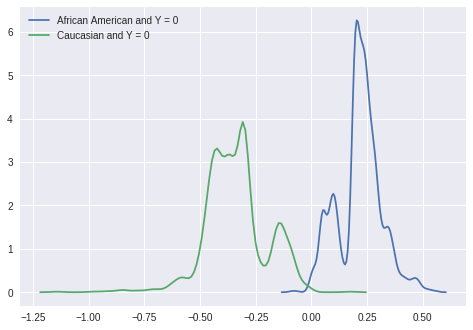

In [0]:
sns.kdeplot(y_0_afam_values[:,0], label = 'African American and Y = 0')
sns.kdeplot(y_0_caucasian_values[:,0], label = 'Caucasian and Y = 0')

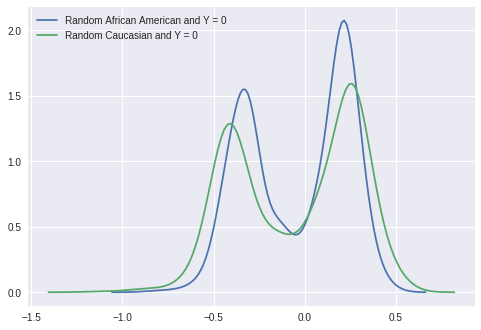

In [0]:
sns.kdeplot(y_0_afam_random_values[:,0], label = 'Random African American and Y = 0')
sns.kdeplot(y_0_caucasian_random_values[:,0], label = 'Random Caucasian and Y = 0')

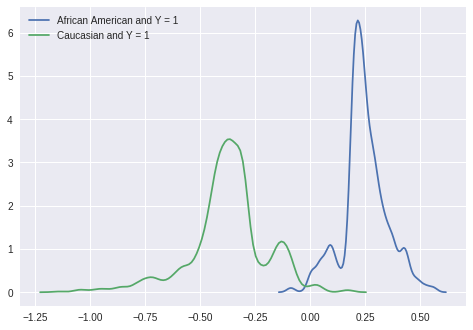

In [0]:
sns.kdeplot(y_1_afam_values[:,0], label = 'African American and Y = 1')
sns.kdeplot(y_1_caucasian_values[:,0], label = 'Caucasian and Y = 1')

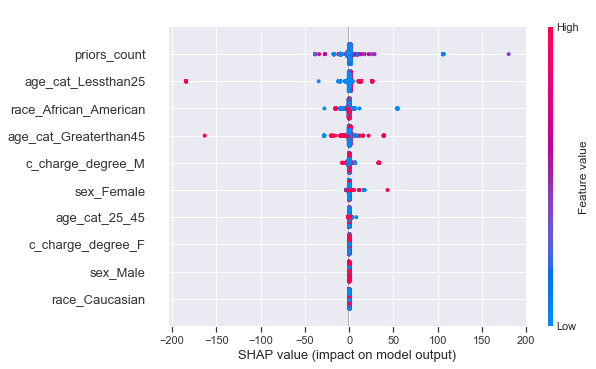

In [48]:
# Normalizing is uneffective there is a constant term we are ignoring
row_sums = shap_values.sum(axis=1)
ba = shap_values/row_sums[:, np.newaxis]
shap.summary_plot(ba, X)